# Анализ и прогнозирование неоднородных временных рядов, БИ

## НИУ ВШЭ, 2022-23 учебный год

### Домашнее задание №5. Анализ и прогнозирование временных рядов

Задание выполнила: Кривоножкина Анна 

### Общая информация

__Дата выдачи:__ 10.12.2022

__Дедлайн:__ 04:00 27.12.2022

### Оценивание и штрафы

Каждое задание оценивается в разное количество баллов. Балл за задание указан в скобках после номера задания.

Общая максимальная сумма баллов по всем заданиям составляет: 138 баллов и 73 бонусных балла.

Оценка за ДЗ вычисляется по следующей формуле:

$$
s_{\text{ts}} \times 10/138 ,
$$

где $s_{\text{ts}}$  — количество баллов, которое вы набрали в сумме по всем заданиям.

При этом, поскольку бонусные баллы суммируются вместе с обычными, имеется возможность получить оценку выше 10 за это ДЗ. Таким образом, исходя из общей суммы баллов, максимально возможная оценка за ДЗ составляет 15,28.

За сдачу домашнего задания позже срока на итоговую оценку за задание накладывается штраф в размере 1 **вторичный** балл в день, но  задержка не может быть больше **трех дней**.

*Примечание. Домашнее задание из-за своего объема весит как два домашних задания в итоговой формуле оценки.*

__Внимание!__ Домашнее задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.

### Формат сдачи

Загрузка файлов с решениями происходит в системе [Anytask](https://anytask.org/). Необходимо загружать файл с расширением .ipynb (питоновский ноутбук)

Инвайт для подключения к странице курса в системе - указан для каждой группы в нашем телеграмм-канале

### О задании

Проблемой короновируса COVID-19, беспокоившего весь мир на протяжении последних нескольких лет, занимались и занимаются ученые по всему миру. В стороне не осталось и комьюнити Data scientist-ов, которые не только пытались в момент пандемии предсказать ее развитие, но также старались помочь определить наиболее значимые факторы, влияющие на распространение заразы. Например на небезызвестном [Kaggle](https://www.kaggle.com/tags/covid19).

В данном домашнем задании вы попрактикуетесь в анализе и прогнозировании временных рядов, работая с ежедневно обновлявшимися во время пандемии данными из [репозитория](https://github.com/datasets/covid-19), а конкретно [time-series-19-covid-combined.csv](https://github.com/datasets/covid-19/blob/master/data/time-series-19-covid-combined.csv).

Вам предстоит изучить имеющиеся данные, попробовать найти некоторые закономерности и ответить на вопросы. Ниже представлены задания как исследовательского характера, где приветствуется инициативность, так и чисто тренировочного характера - где необходимо использовать изученные на семинаре инструменты для работы с временными рядами. **Не забывайте сопровождать ваш код развернутыми комментариями и выводами.** Чем их больше и чем они качественнее, тем лучше и выше вероятность получения максимальной оценки за домашнее задание. Не болейте!

In [ ]:
#!pip install orbit-ml
#!pip install orbit
#!pip install prophet
#!pip install sktime[all_extras]

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

import statsmodels.api as sma
import statsmodels.formula.api as smfa
import statsmodels.tsa.stattools as smstt
%matplotlib inline

pd.options.display.float_format = '{:.2f}'.format

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 15)

In [11]:
df = pd.read_csv('time-series-19-covid-combined.csv')

In [12]:
df.head()

,Date,Country/Region,Province/State,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,0,0.00,0
1,2020-01-23,Afghanistan,NaN,0,0.00,0
2,2020-01-24,Afghanistan,NaN,0,0.00,0
3,2020-01-25,Afghanistan,NaN,0,0.00,0
4,2020-01-26,Afghanistan,NaN,0,0.00,0


Приведем столбец с датой к соответствующему типу данных и переименуем столбцы

In [13]:
df['Date'] = pd.to_datetime(df['Date'])
df['Country'] = df['Country/Region']
df = df.drop('Country/Region',axis = 1)
df.tail()

,Date,Province/State,Confirmed,Recovered,Deaths,Country
231739,2022-04-12,NaN,247094,0.00,5460,Zimbabwe
231740,2022-04-13,NaN,247160,0.00,5460,Zimbabwe
231741,2022-04-14,NaN,247208,0.00,5462,Zimbabwe
231742,2022-04-15,NaN,247237,0.00,5462,Zimbabwe
231743,2022-04-16,NaN,247237,0.00,5462,Zimbabwe


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231744 entries, 0 to 231743
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date            231744 non-null  datetime64[ns]
 1   Province/State  72624 non-null   object        
 2   Confirmed       231744 non-null  int64         
 3   Recovered       218688 non-null  float64       
 4   Deaths          231744 non-null  int64         
 5   Country         231744 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 10.6+ MB


In [15]:
# здесь мы сначала получили срез дата фрейма со столбцом Province/State, где в каждой строке указано True, если значение есть и False, если его нет.
# Затем мы к этому срезу еще добавили столбец Country и использовали функцию unique(), чтобы вывести в виде кортежа уникальные значения в столбце Country
df[df['Province/State'].notna()]['Country'].unique()

array(['Australia', 'Canada', 'China', 'Denmark', 'France', 'Netherlands',
       'New Zealand', 'United Kingdom'], dtype=object)

Данные о заболеваемости в штатах и в регионах присутствуют только в ряде стран, поэтому удалим этот столбец, сгруппировав данные по стране и дате

In [16]:
df = pd.DataFrame(df.groupby(['Country','Date']).sum()).reset_index()
df.head()

,Country,Date,Confirmed,Recovered,Deaths
0,Afghanistan,2020-01-22,0,0.00,0
1,Afghanistan,2020-01-23,0,0.00,0
2,Afghanistan,2020-01-24,0,0.00,0
3,Afghanistan,2020-01-25,0,0.00,0
4,Afghanistan,2020-01-26,0,0.00,0


In [ ]:
df.Country.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Gua

In [17]:
df.loc[df['Country']=='Taiwan*', 'Country'] = 'Taiwan'
df.Country.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Gua

В датасете имеются данные о стране "Winter Olympics 2022" и "Summer Olympics 2020" удалим их

In [18]:
df = df.drop(df[df['Country'] == "Winter Olympics 2022"].index)
df = df.drop(df[df['Country'] == "Summer Olympics 2020"].index)
df = df.drop(df[df['Country'] == "MS Zaandam"].index)
df['Country'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Gua

Также, в названии страны "Congo" допущены ошибки, исправим их

In [19]:
congo_statistics = df[(df['Country']=='Congo (Brazzaville)') | (df['Country']=='Congo (Kinshasa)')]
congo_statistics = pd.DataFrame(congo_statistics.groupby('Date').sum().reset_index())
congo_statistics = congo_statistics.assign(Country = 'Congo')[['Country','Date','Confirmed','Recovered','Deaths']]
congo_statistics.head()

,Country,Date,Confirmed,Recovered,Deaths
0,Congo,2020-01-22,0,0.00,0
1,Congo,2020-01-23,0,0.00,0
2,Congo,2020-01-24,0,0.00,0
3,Congo,2020-01-25,0,0.00,0
4,Congo,2020-01-26,0,0.00,0


Уберём из дата сета те строки, которые содержали в себе Congo (Brazzaville) и Congo (Kinshasa) и добавим к дата сету то, что мы создали на шаге ранее


In [20]:
df = df.drop(df[(df['Country']=='Congo (Brazzaville)') | (df['Country']=='Congo (Kinshasa)')].index)
df = pd.concat([df, congo_statistics]).sort_values(by = ['Country']).reset_index()
df.Country.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo', 'Costa Rica', "Cote d'Ivoire", 'Croatia',
       'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Diamond Princess',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada',
       'Guatemala', 'Guinea', 'Guinea-Bissau'

In [ ]:
df = df.drop('index', axis = 1)
df.head()

## Раздел 1. Первичный анализ временных рядов (45 баллов и 15 бонусных баллов)

#### 1.1. (5 баллов) 

Определите границы исследуемого периода, количество заболевших, погибших, выздоровевших. Отобразите на карте распространение болезни. Что вы видите? Какие выводы можно сделать?

Определим временные границы исследуемого датасета

In [23]:
df.Date.min()

Timestamp('2020-01-22 00:00:00')

In [24]:
df.Date.max()

Timestamp('2022-04-16 00:00:00')

У нас имеются данные с 22 января 2020 до 16 апреля 2022 

In [25]:
df.groupby('Date').sum()['Confirmed'].max()

504154050

In [26]:
df.groupby('Date').sum()['Recovered'].max()

129493083.0

In [27]:
df.groupby('Date').sum()['Deaths'].max()

6197157

По всем странам суммарное количество заболевших на 16 апреля 2022 года: 504155459
По всем странам суммарное количество выздоровевших (до 5 августа 2021 года): 129493090
По всем странам суммарное количество умерших на 16 апреля 2022 года: 6197159

Посмотрим распределение по странам подтвержденных случаев заражения на карте

Т.к. могут возникнуть проблемы с загрузкой карты(она судя по всему очень много берет оперативки), я запустила эту ячейку заранее и сделала скриншот.

In [ ]:
import plotly.express as pltx

In [ ]:
#plot1 = pltx.choropleth(df, locations="Country", color='Confirmed', locationmode='country names')
#plot2 = pltx.choropleth(df, locations="Country", color='Deaths', locationmode='country names')
#plot3 = pltx.choropleth(df, locations="Country", color='Recovered', locationmode='country names')

In [ ]:
from IPython.display import Image
Image(url= "./confirmed_map.png", width=800, height=600)

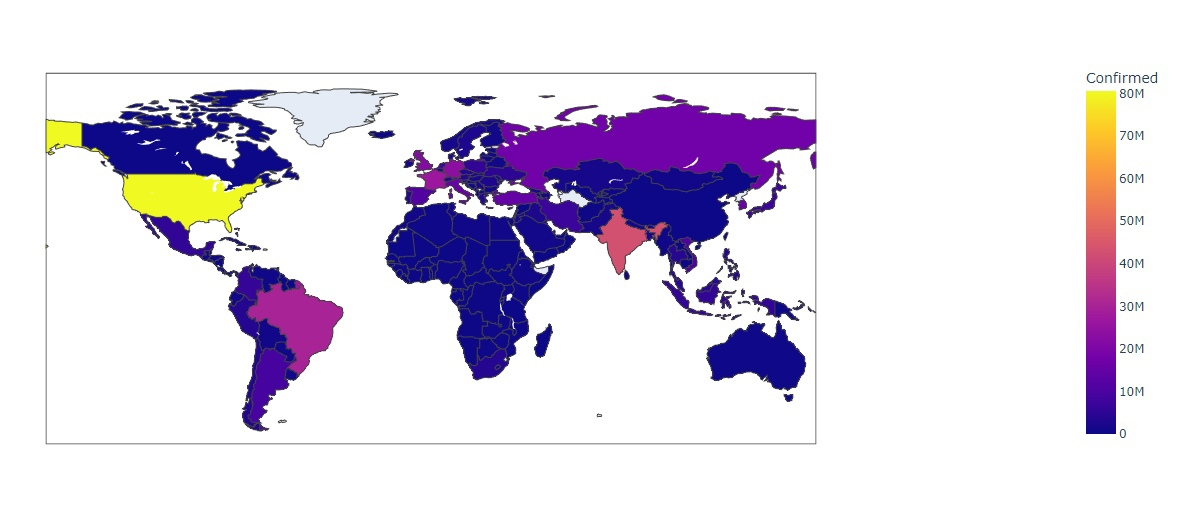

In [ ]:
Image(url= "./deaths_map.png", width=800, height=600)

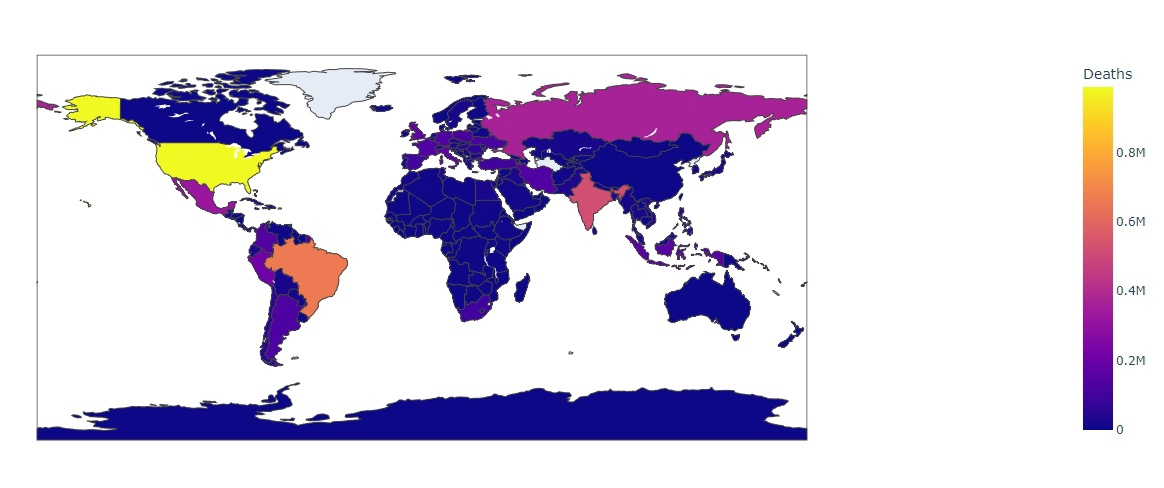

Проанализировав полученные результаты, можно сделать вывод, что странами с наибольшим количеством зараженных жителей (или о которых имеется больше данных) являются: США, Бразилия, Индия. Эти же страны и являются лидерами по смертности от коронавируса.

#### 1.2. (5 баллов)

Определите количество стран, которые подтвердили случаи заражения 
- на 1 марта 2020 года
- на 1 июня 2020 года
- на 1 октября 2020 года
- на 1 января 2021 года
- на 1 января 2022 года
- на момент окончания исследуемого периода.

Визуализируйте рост количества стран, подтвердивших случаи заражения
- по дням 
- по неделям
- по месяцам. 


Какие выводы можно сделать из этих графиков?

  *Примечание. В анализе временных рядов иногда необходимо изменить частоту дискретизации (Resampling). Такая операция может понадобится, когда имеющихся данных недостаточно или их, наоборот, слишком много. Может не устраивать имеющаяся частота или просто хочется посмотреть на данные с более общего ракурса.*

  *Различают два вида изменения частоты: повышение (Upsampling) и понижение (Downsampling). При повышении временной ряд пересчитывается с низкой частоы на более высокую частоту (например от годовой до месячной частоты). В таком случае процесс включает в себя заполнение или интерполяцию появившихся пропусков в данных. При понижении временной ряд передискретизируется с высокой частоты на низкую (наример с еженедельной на месячную частоту). Это включает в себя агрегацию существующих данных.*

In [ ]:
df.head()

,Country,Date,Confirmed,Recovered,Deaths
0,Afghanistan,2020-01-22,0,0.00,0
1,Afghanistan,2021-07-13,135889,82586.00,5849
2,Afghanistan,2021-07-14,136643,82586.00,5923
3,Afghanistan,2021-07-15,137853,82586.00,5983
4,Afghanistan,2021-07-16,139051,82586.00,6072


Создадим отдельный датасет, в котором для каждой страны будут храниться даты, когда появились первые случаи заражения

In [ ]:
pandemic_start = pd.DataFrame(columns = ['Country','Date','Confirmed','Recovered','Deaths'])
for country in df['Country'].unique():
    country_statistics = df[df['Country']==country]
    start_date = country_statistics[(df['Confirmed']>0)|(df['Recovered']>0)|(df['Deaths']>0)].Date.min()
    country_first = df[(df['Country']==country)&(df['Date']==start_date)]
    pandemic_start = pd.concat([country_first, pandemic_start])
    
pandemic_start = pandemic_start.sort_values('Date')
pandemic_start.head()

,Country,Date,Confirmed,Recovered,Deaths
138720,Taiwan,2020-01-22 00:00:00,1,0.00,0
141168,Thailand,2020-01-22 00:00:00,4,2.00,0
70995,Japan,2020-01-22 00:00:00,2,0.00,0
30730,China,2020-01-22 00:00:00,548,28.00,17
147417,US,2020-01-22 00:00:00,1,0.00,0


In [ ]:
print('На 1 марта 2020 года ', pandemic_start[pandemic_start['Date']<=datetime(2020,3,1)].size,' страны подтвердили случаи заражения.')
print('На 1 июня 2020 года ', pandemic_start[pandemic_start['Date']<=datetime(2020,6,1)].size,' стран подтвердили случаи заражения.')
print('На 1 октября 2020 года ', pandemic_start[pandemic_start['Date']<=datetime(2020,10,1)].size,' стран подтвердили случаи заражения.')
print('На 1 января 2021 года ', pandemic_start[pandemic_start['Date']<=datetime(2021,1,1)].size,' стран подтвердили случаи заражения.')
print('На 1 января 2022 года ', pandemic_start[pandemic_start['Date']<=datetime(2022,1,1)].size,' стран подтвердили случаи заражения.')
print('На 16 апреля 2022 года ', pandemic_start[pandemic_start['Date']<=datetime(2022,4,16)].size,' стран подтвердили случаи заражения.')

На 1 марта 2020 года  335  страны подтвердили случаи заражения.
На 1 июня 2020 года  925  стран подтвердили случаи заражения.
На 1 октября 2020 года  925  стран подтвердили случаи заражения.
На 1 января 2021 года  945  стран подтвердили случаи заражения.
На 1 января 2022 года  970  стран подтвердили случаи заражения.
На 16 апреля 2022 года  970  стран подтвердили случаи заражения.


Создадим временной ряд, отображающий изменения в количестве зараженных стран по дням

In [ ]:
pandemic = pd.DataFrame(pd.date_range(start='22/1/2020',end = '16/04/2022'), columns = ['Date'])
infected_countries_number = []
for date in pandemic.Date:
    infected_countries_number.append(pandemic_start[pandemic_start['Date']<=date].size)

pandemic['infected_countries_number'] = infected_countries_number
pandemic.head()

,Date,infected_countries_number
0,2020-01-22,30
1,2020-01-23,45
2,2020-01-24,50
3,2020-01-25,60
4,2020-01-26,65


График изменения количества зараженных стран по дням

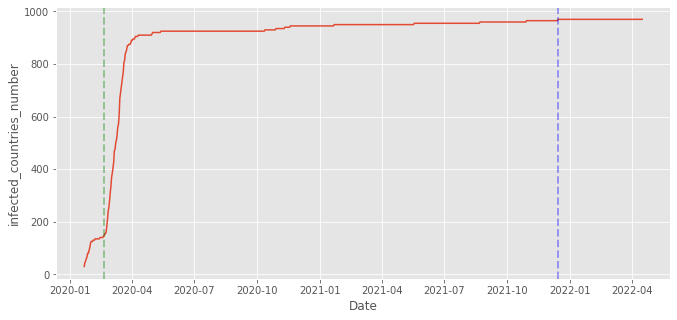

In [ ]:
fig = plt.gcf()
fig.set_size_inches(11, 5)

sns.lineplot(data = pandemic, markers=True, x = 'Date', y = 'infected_countries_number')
plt.axvline(x = datetime(2020,2,20),ymin = 0.001, ls='--', lw=2, alpha=0.35, ymax = 1.5,c='g')
plt.axvline(x = datetime(2021,12,14),ymin = 0.001, ls='--', lw=2, alpha=0.35, ymax = 1.5,c='b')

Создадим временной ряд, отображающий изменения в количестве зараженных стран по неделям

In [ ]:
pandemic_weeks = pd.DataFrame()
weeks = pd.DataFrame(pd.date_range(start='22/1/2020',end = '16/04/2022',freq='W'), columns = ['Date'])
infected_countries_number = []
for week in weeks['Date']:
    infected_countries_number.append(int(pandemic[pandemic['Date'] == week]['infected_countries_number']))

pandemic_weeks = pd.DataFrame(weeks)
pandemic_weeks['infected_countries_number'] = infected_countries_number 
pandemic_weeks.head()

,Date,infected_countries_number
0,2020-01-26,65
1,2020-02-02,125
2,2020-02-09,135
3,2020-02-16,140
4,2020-02-23,160


График изменения количества зараженных стран по неделям

<AxesSubplot:xlabel='Date', ylabel='infected_countries_number'>

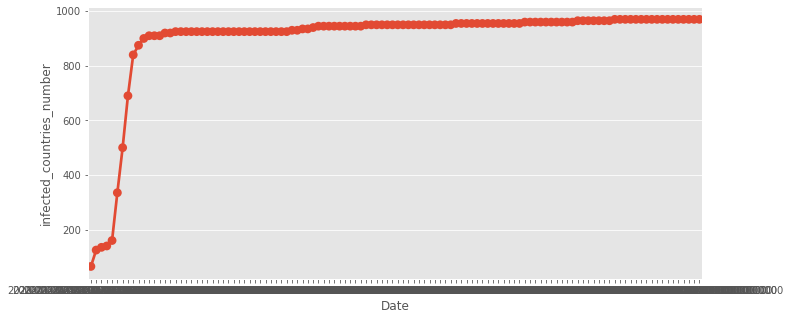

In [ ]:
fig = plt.gcf()
fig.set_size_inches(11, 5)

sns.pointplot(data = pandemic_weeks, markers=["o"], x = 'Date', y = 'infected_countries_number',dashes= False)

Создадим временной ряд, отображающий изменения в количестве зараженных стран по месяцам

In [ ]:
pandemic_months = pd.DataFrame()
months = pd.DataFrame(pd.date_range(start='22/1/2020',end = '16/04/2022',freq='M'), columns = ['Date'])
infected_countries_number = []
for month in months['Date']:
    infected_countries_number.append(int(pandemic[pandemic['Date'] == month]['infected_countries_number']))

pandemic_months = pd.DataFrame(months)
pandemic_months['infected_countries_number'] = infected_countries_number 
pandemic_months.head()

,Date,infected_countries_number
0,2020-01-31,115
1,2020-02-29,310
2,2020-03-31,890
3,2020-04-30,915
4,2020-05-31,925


График изменения количества зараженных стран по месяцам

<AxesSubplot:xlabel='Date', ylabel='infected_countries_number'>

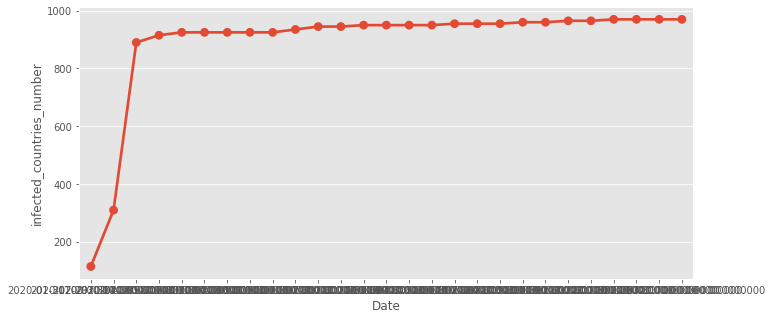

In [ ]:
fig = plt.gcf()
fig.set_size_inches(11, 5)

sns.pointplot(data = pandemic_months, markers=["o"], x = 'Date', y = 'infected_countries_number',dashes= False)

Проанализировав получившиеся графики, можно сделать вывод, что было два резких скачка заболеваемости: с 22 января 2020 по начало февраля и с конца февраля по начало апреля. Также, с 14 декабря 2021 года во всех странах уже присутствовал хотя бы 1 заболевший

#### 1.3. (5 баллов)

Визуализируйте мировые тренды по числу 

- заболевших 
- погибших 
- выздоровивших.

Постройте графики, которые отражают летальность от вируса 

- в разных странах 
- на разных континентах. 

Какие выводы можно сделать?

Построим график изменения количества заболевших, выдоровевших и погибших

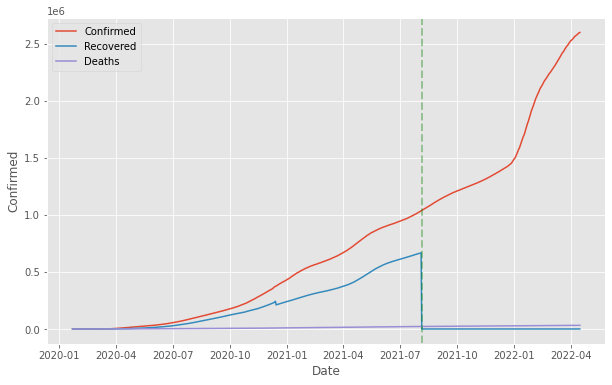

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10,6)

sns.lineplot(data = df, x = 'Date', y = 'Confirmed', ci=None)
sns.lineplot(data = df,  x = 'Date', y = 'Recovered', ci=None)
sns.lineplot(data = df, x = 'Date', y = 'Deaths', ci=None)
plt.legend(labels = ['Confirmed','Recovered','Deaths'])
plt.axvline(x = datetime(2021,8,5),ymin = 0.001, ls='--', lw=2, alpha=0.35, ymax = 1.5,c='g')

На графике можно заметить резкое падение количества выздоровевших до нуля 5 августа 2021 года. Скорее просто перестали собирать данные о выздоровевших.
Также, график отображающий количество заболевших практически не меняет угол наклона, поэтому можно предположить, что динамика увеличения количества заболевших будет примерно на таком-же уровне.  

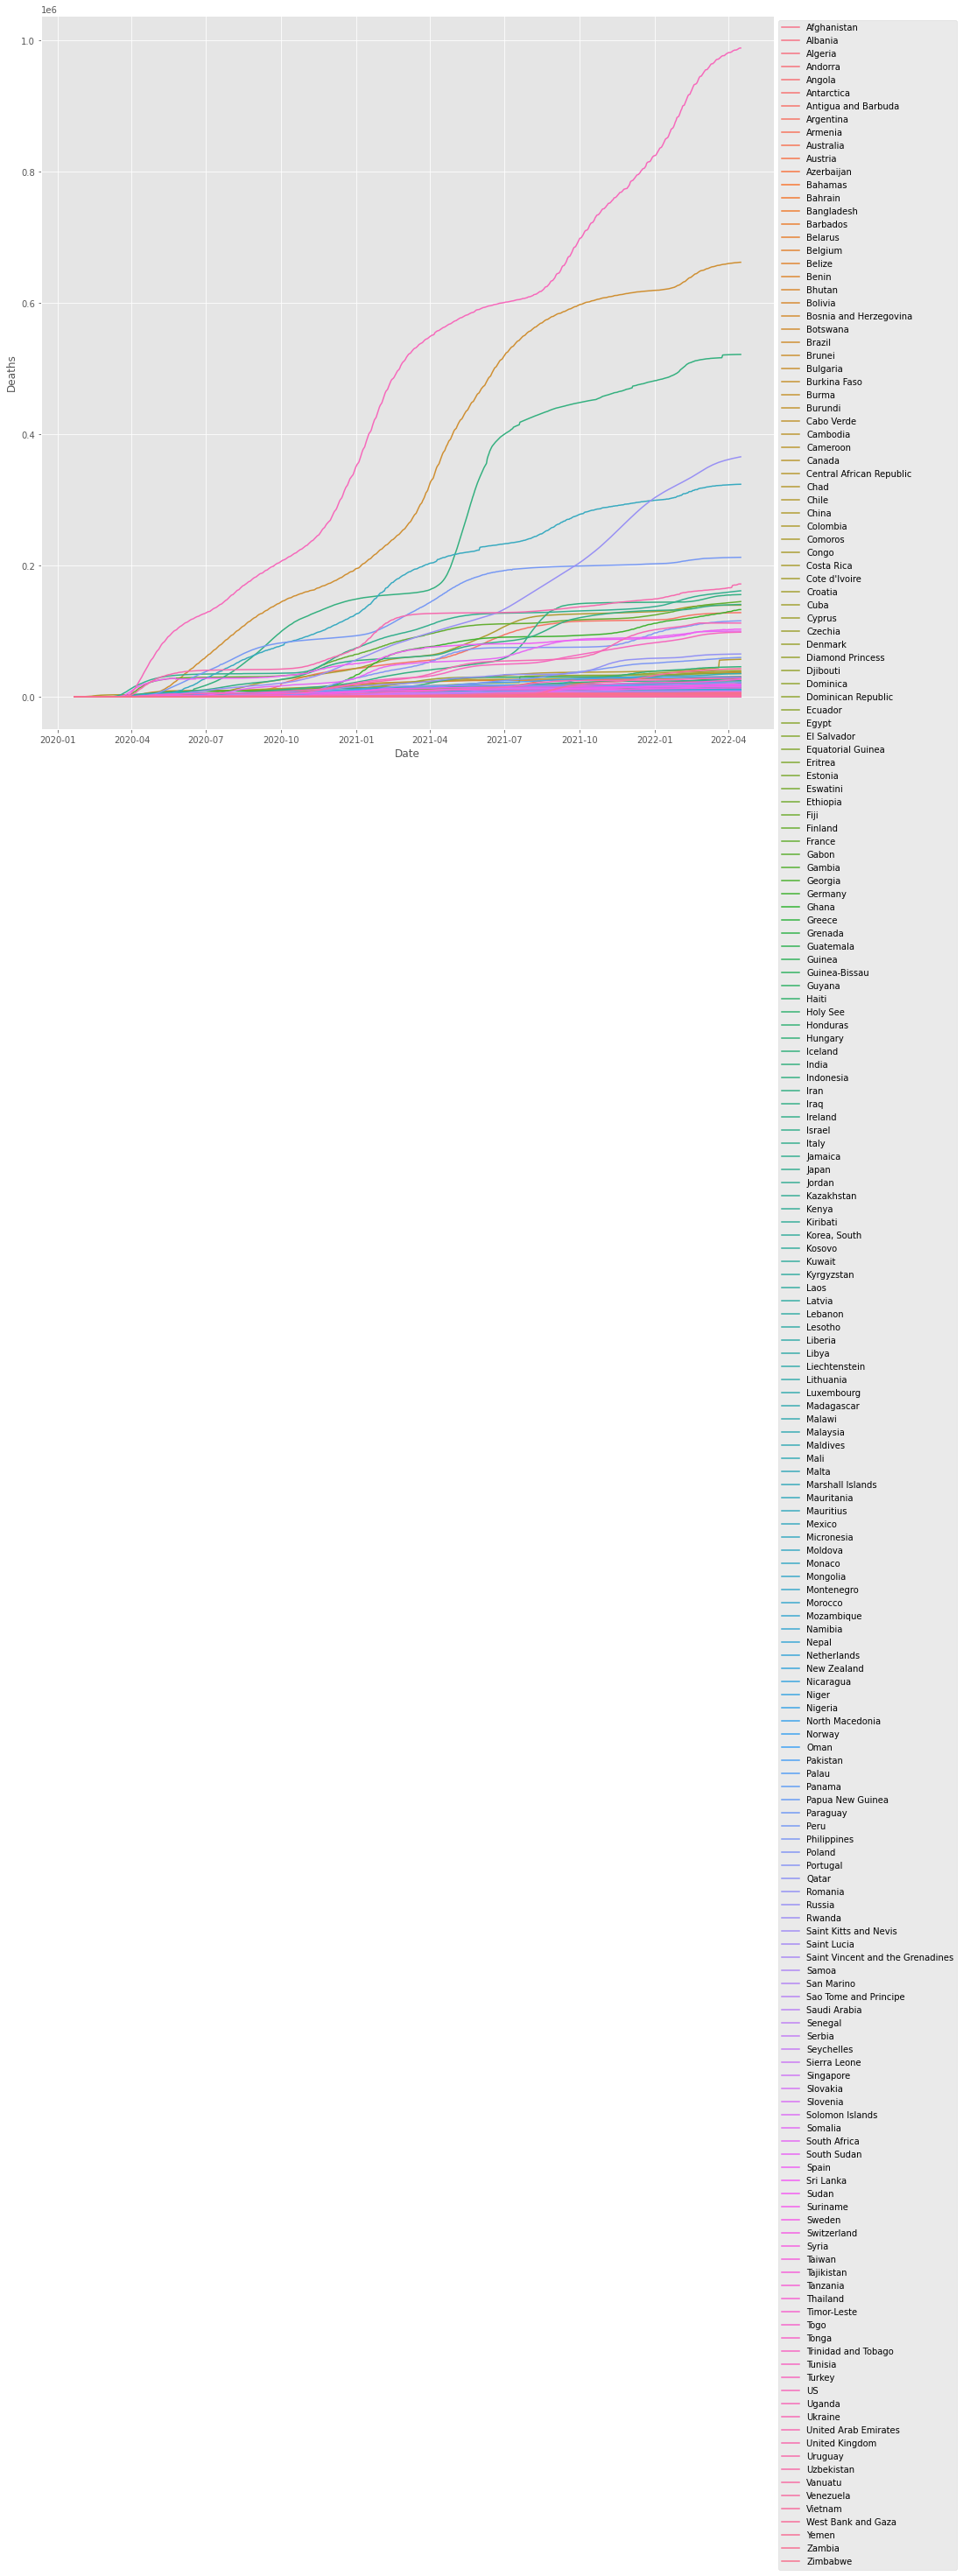

In [ ]:
sns.lineplot(data = df, x = 'Date', y = 'Deaths', ci=None, hue = 'Country')
plt.legend(bbox_to_anchor=(1, 1), loc=2)

Добавим параметр смертности на 1000 человек для каждой страны

In [ ]:
df['Deaths_on_1000'] = 1000 * df['Deaths']/df['Confirmed']

Сравним уровень смертности на 1000 человек на 16 апреля 2022 года

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


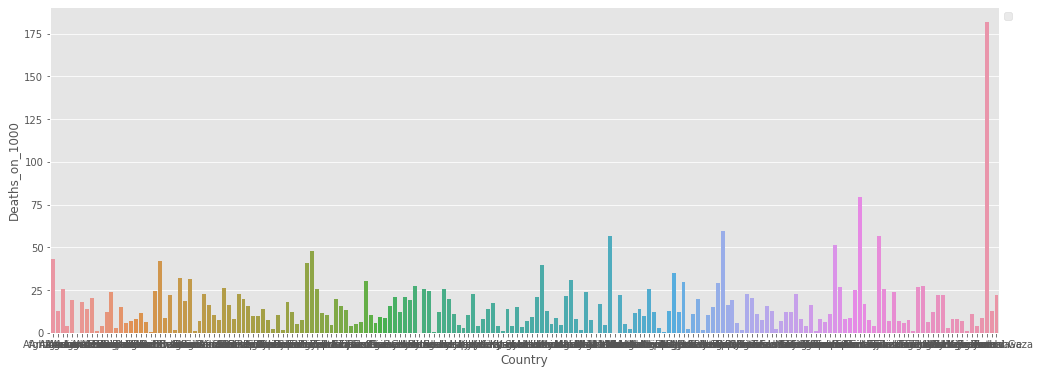

In [ ]:
fig = plt.gcf()
fig.set_size_inches(17,6)

sns.barplot(data = df[df['Date']=='2022-04-16'], x = 'Country', y = 'Deaths_on_1000')
plt.legend(bbox_to_anchor=(1, 1), loc=2)

In [ ]:
df[df['Date']=='2022-04-16'][df['Deaths_on_1000']>50]

,Country,Date,Confirmed,Recovered,Deaths,Deaths_on_1000
93814,Mexico,2022-04-16,5726668,0.00,323938,56.57
112329,Peru,2022-04-16,3555139,0.00,212619,59.81
130970,Somalia,2022-04-16,26471,0.00,1361,51.41
135430,Sudan,2022-04-16,62057,0.00,4929,79.43
137905,Syria,2022-04-16,55769,0.00,3149,56.47
156264,Yemen,2022-04-16,11817,0.00,2148,181.77


Наиболее высокий уровень смертности в таких странах как: Йемен и Судан, но если обратить внимание на общее количество зараженных, то лидерами я бы назвала Мексику и Перу, т.к. там на 5 и 3 млн. заболевших 320 и 212 тыс. умерших

In [ ]:
#plot1 = pltx.choropleth(df, locations="Country", color='Deaths_on_1000', locationmode='country names', range_color=(0, 200))

from IPython.display import Image
Image(url= "./deaths_on_1000.png", width=800, height=600)

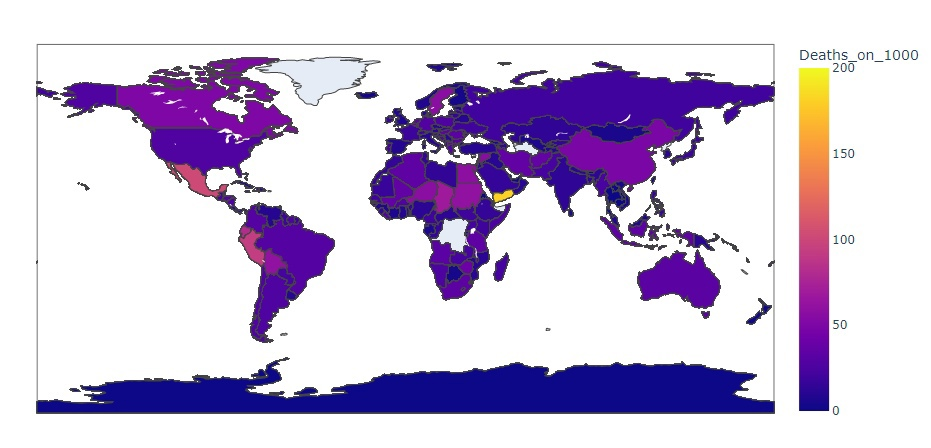

Посмотрев на летальность по континентам, можно сказать, что какого-то четкого распределения нет. Разве что в Австралии и Евразии уровень смертности относительно ниже, чем  на других континентах

#### 1.4. (5 баллов)

Визуализируйте и сравните, как распространялась болезнь в разных странах и на разных континентах по дням с первого зарегистрированного случая заболевания. Определите количество дней для каждой страны со дня первого зарегестрированного случая. Какие тенденции вы видите?

Т.к. стран очень много, для анализа я взяла США, Перу и Россию (все 3 с разных континентов)

In [ ]:
print(df[((df['Country']=='Peru')) & ((df['Confirmed']!=0)|(df['Recovered']!=0)|(df['Deaths']!=0))].sort_values('Date').iloc[0])
print(df[((df['Country']=='US')) & ((df['Confirmed']!=0)|(df['Recovered']!=0)|(df['Deaths']!=0))].sort_values('Date').iloc[0])
print(df[((df['Country']=='Russia')) & ((df['Confirmed']!=0)|(df['Recovered']!=0)|(df['Deaths']!=0))].sort_values('Date').iloc[0])

Country                          Peru
Date              2020-03-06 00:00:00
Confirmed                           1
Recovered                        0.00
Deaths                              1
Deaths_on_1000                1000.00
Name: 112081, dtype: object
Country                            US
Date              2020-01-22 00:00:00
Confirmed                           1
Recovered                        0.00
Deaths                              0
Deaths_on_1000                   0.00
Name: 147417, dtype: object
Country                        Russia
Date              2020-01-31 00:00:00
Confirmed                           2
Recovered                        0.00
Deaths                              0
Deaths_on_1000                   0.00
Name: 116960, dtype: object


Первый зараженный в США появился в первый же день, о котором имеется статистика(возможно данные начали собирать, когда в их стране появился первый зараженный). В России появился 2 первых зараженных появилось, а вот в Перу - спустя полтора месяца после начала пандемии в других странах.

In [ ]:
df_countries = df[((df['Country']=='Peru')|(df['Country']=='US')|(df['Country']=='Russia'))]
df_countries.Country.unique()

array(['Peru', 'Russia', 'US'], dtype=object)

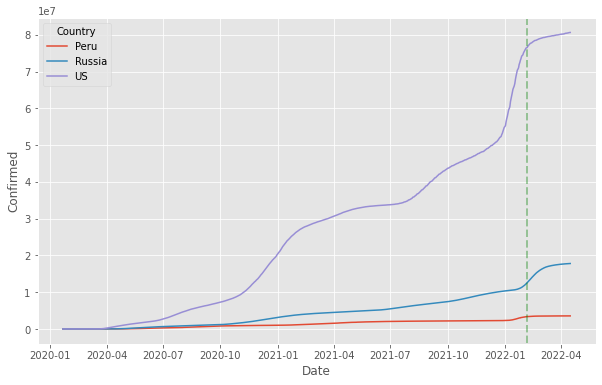

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10,6)

sns.lineplot(data = df_countries, x = 'Date', y = 'Confirmed', hue = 'Country')
plt.axvline(x = datetime(2022,2,5),ymin = 0.001, ls='--', lw=2, alpha=0.35, ymax = 1.5,c='g')

<AxesSubplot:xlabel='Date', ylabel='Recovered'>

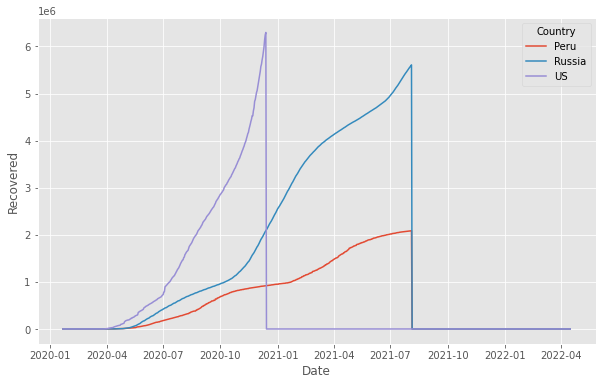

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10,6)

sns.lineplot(data = df_countries, x = 'Date', y = 'Recovered', hue = 'Country')

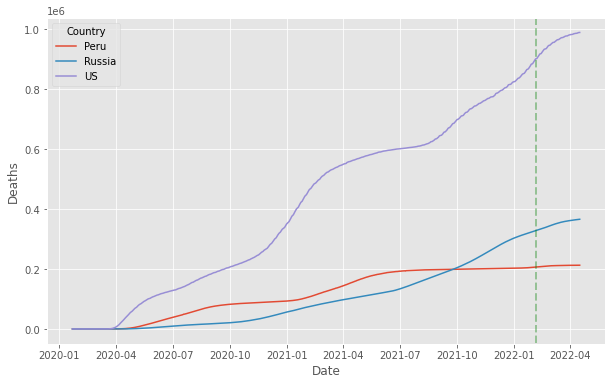

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10,6)

sns.lineplot(data = df_countries, x = 'Date', y = 'Deaths', hue = 'Country')
plt.axvline(x = datetime(2022,2,5),ymin = 0.001, ls='--', lw=2, alpha=0.35, ymax = 1.5,c='g')

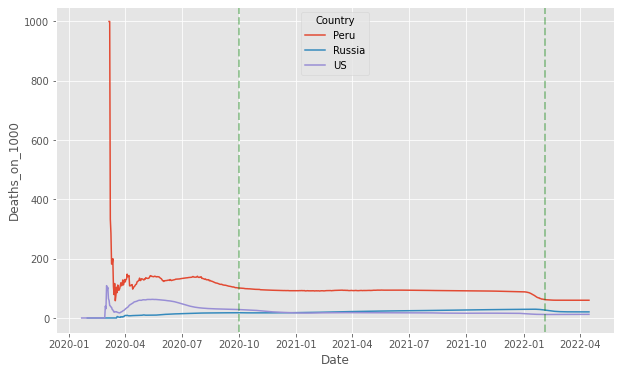

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10,6)

sns.lineplot(data = df_countries, x = 'Date', y = 'Deaths_on_1000', hue = 'Country')
plt.axvline(x = datetime(2020,10,1),ymin = 0.001, ls='--', lw=2, alpha=0.35, ymax = 1.5,c='g')
plt.axvline(x = datetime(2022,2,5),ymin = 0.001, ls='--', lw=2, alpha=0.35, ymax = 1.5,c='g')

Из общих тенденций, можно заметить, что в начале февраля 2022 года начался спад заболеваемости и смертности во всех странах. Также, в начале октября ситуация с относительной смертностью стала более стабильной во всех странах, а в начале февраля 2022 года еще и улучшилась.

#### 1.5. (5 баллов)

Визуализируйте и оцените как развивалась ситуация в России по сравнению с остальными миром. Как вы будете осуществлять сравнение? Почему? Какие выводы можно сделать?

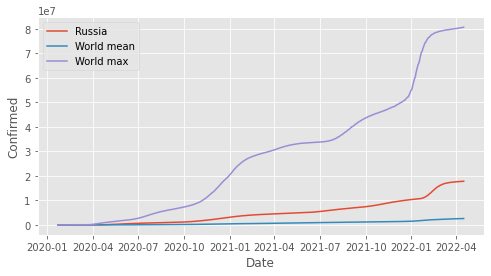

In [ ]:
fig = plt.gcf()
fig.set_size_inches(8,4)

sns.lineplot(data = df[df['Country']=='Russia'], x = 'Date', y = 'Confirmed', ci=None)
sns.lineplot(data = df.groupby('Date').mean().reset_index(), x = 'Date', y = 'Confirmed', ci=None)
sns.lineplot(data = df.groupby('Date').max().reset_index(), x = 'Date', y = 'Confirmed', ci=None)

plt.legend(labels = ['Russia','World mean', 'World max'])

Если сравнить среднее количество подтвержденных случаев во всем мире с Россией, то Россия будет сильно обгонять среднее по миру, но т.к. население у большинства стран меньше России, такое сравнение нельзя проводить. Также, для сравнения - приведен график (фиолетовый цвет) максимального количества заражений для всех стран и Россия сильно отстает по количеству заражений от него.

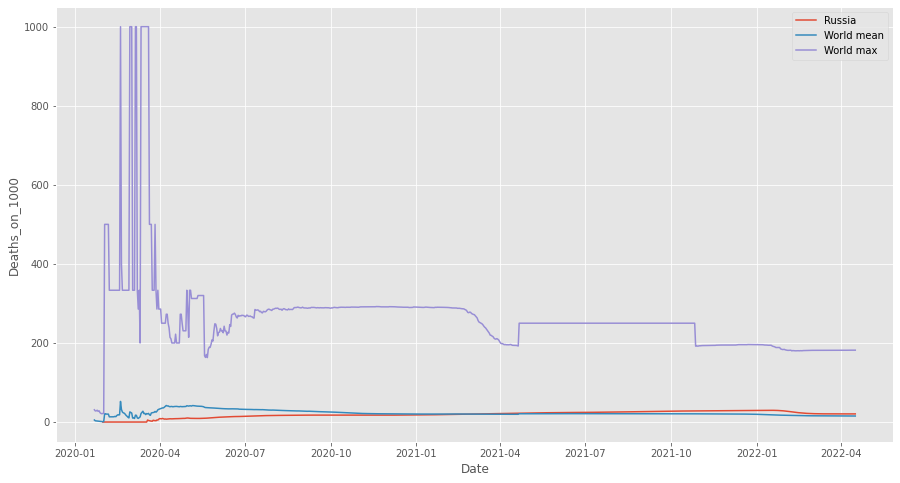

In [ ]:
fig = plt.gcf()
fig.set_size_inches(15,8)

sns.lineplot(data = df[(df['Country']=='Russia')], x = 'Date', y = 'Deaths_on_1000', ci=None)
sns.lineplot(data = df.groupby('Date').mean().reset_index(), x = 'Date', y = 'Deaths_on_1000', ci=None)
sns.lineplot(data = df.groupby('Date').max().reset_index(), x = 'Date', y = 'Deaths_on_1000', ci=None)

plt.legend(labels = ['Russia','World mean', 'World max'])

А вот коэффициенты смертности на 1000 человек мы уже можем сравнивать. Проанализировав графики, можно увидеть, что коэффициент смертности России сильно меньше максимального по миру, и примерно сопоставим со средним по миру (сначала был меньше, потом обогнал где-то в начале 2021 года)

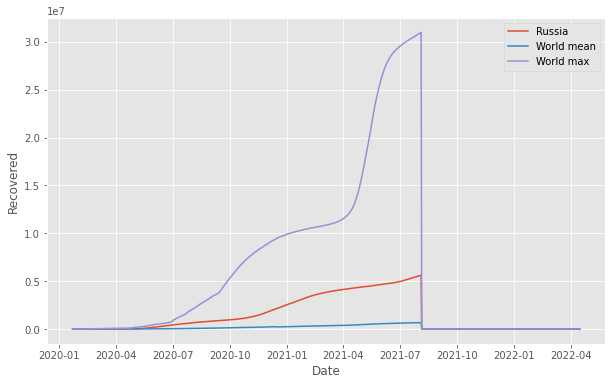

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10,6)

sns.lineplot(data = df[(df['Country']=='Russia')], x = 'Date', y = 'Recovered', ci=None)
sns.lineplot(data = df.groupby('Date').mean().reset_index(), x = 'Date', y = 'Recovered', ci=None)
sns.lineplot(data = df.groupby('Date').max().reset_index(), x = 'Date', y = 'Recovered', ci=None)

plt.legend(labels = ['Russia','World mean', 'World max'])

#### 1.6. (5 баллов)

Определите топ-10 стран, которые лидируют по имеющимся в датасете показателям. Постоянны ли эти лидеры? За какой временной промежуток было бы наиболее правильно брать лидеров, на ваш взгляд? Почему? Сравните насколько быстро развивается ситуация в этих странах. Определите корреляцию.

В качестве временных промежутков, в которых я буду сравнивать показатели заражаемости и смертности по странам, я решила взять: 01.04.2020 (в этот момент в большинстве стран уже был хотя бы 1 зараженный), 01.04.2021 (середина исследуемого периода), 01.04.2022 (конец исследуемого периода, показатель выздоровления в этом периоде проверять не будем, т.к. по нему здесь отсутствуют данные)

**01.04.2020**

<AxesSubplot:xlabel='Country', ylabel='Confirmed'>

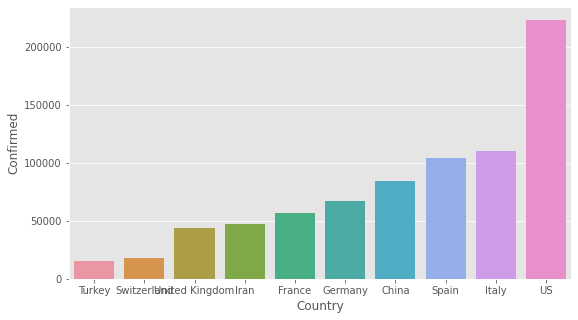

In [ ]:
fig = plt.gcf()
fig.set_size_inches(9,5)

sns.barplot(data = df[df['Date']=='2020-04-01'].sort_values('Confirmed')[-10:], x = 'Country', y = 'Confirmed')

<AxesSubplot:xlabel='Country', ylabel='Deaths'>

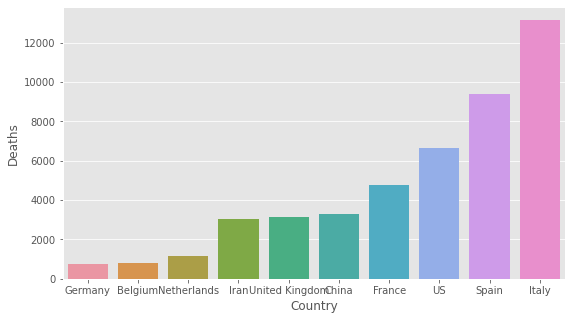

In [ ]:
fig = plt.gcf()
fig.set_size_inches(9,5)

sns.barplot(data = df[df['Date']=='2020-04-01'].sort_values('Deaths')[-10:], x = 'Country', y = 'Deaths')

<AxesSubplot:xlabel='Country', ylabel='Recovered'>

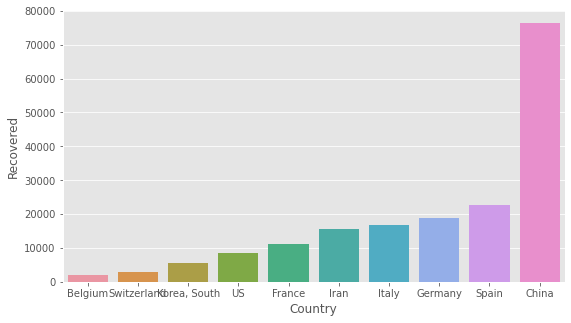

In [ ]:
fig = plt.gcf()
fig.set_size_inches(9,5)

sns.barplot(data = df[df['Date']=='2020-04-01'].sort_values('Recovered')[-10:], x = 'Country', y = 'Recovered')

Проанализировав первый период, можно сделать вывод, что страны входящие в топ 10 по всем показателям, примерно одни и те же, за исключением последних мест. Также, можно выделить, что хоть в Китае количество выздоровевших людей сильно опережало остальные страны, а в Италии и Испании похожая ситуация, но со смертностью.

**01.04.2021**

<AxesSubplot:xlabel='Country', ylabel='Confirmed'>

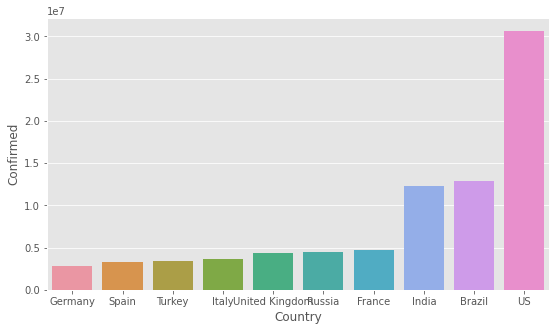

In [ ]:
fig = plt.gcf()
fig.set_size_inches(9,5)

sns.barplot(data = df[df['Date']=='2021-04-01'].sort_values('Confirmed')[-10:], x = 'Country', y = 'Confirmed')

<AxesSubplot:xlabel='Country', ylabel='Deaths'>

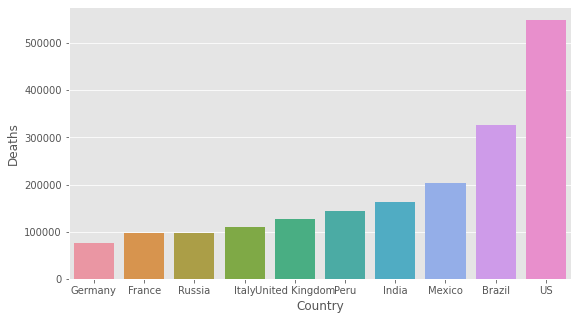

In [ ]:
fig = plt.gcf()
fig.set_size_inches(9,5)

sns.barplot(data = df[df['Date']=='2021-04-01'].sort_values('Deaths')[-10:], x = 'Country', y = 'Deaths')

<AxesSubplot:xlabel='Country', ylabel='Recovered'>

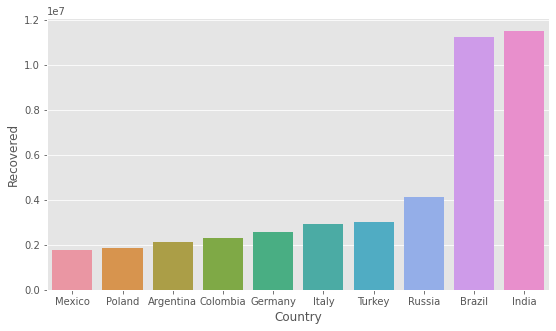

In [ ]:
fig = plt.gcf()
fig.set_size_inches(9,5)

sns.barplot(data = df[df['Date']=='2021-04-01'].sort_values('Recovered')[-10:], x = 'Country', y = 'Recovered')

На основании данного периода можно сделать вывод, что лидеры почти по всем показателям у нас сменились (кроме США), в Европе ситуация со смертностью улучшилась, а в Южной и Северной Америке заметно ухудшилась

**01.04.2022**

<AxesSubplot:xlabel='Country', ylabel='Confirmed'>

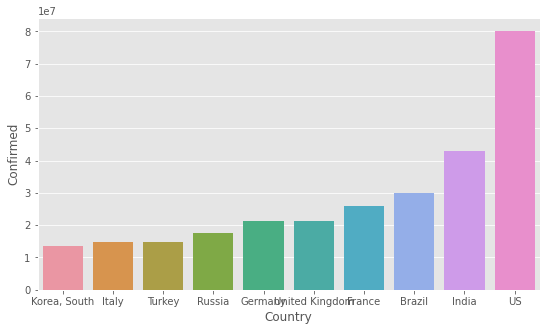

In [ ]:
fig = plt.gcf()
fig.set_size_inches(9,5)

sns.barplot(data = df[df['Date']=='2022-04-01'].sort_values('Confirmed')[-10:], x = 'Country', y = 'Confirmed')

<AxesSubplot:xlabel='Country', ylabel='Deaths'>

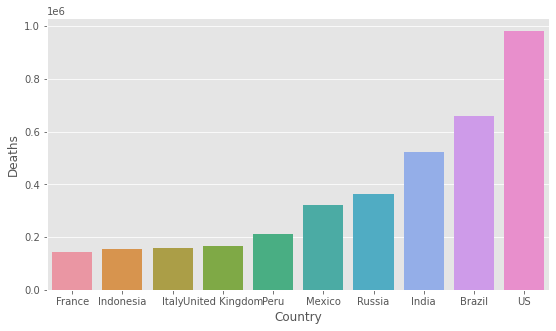

In [ ]:
fig = plt.gcf()
fig.set_size_inches(9,5)

sns.barplot(data = df[df['Date']=='2022-04-01'].sort_values('Deaths')[-10:], x = 'Country', y = 'Deaths')

За год топ стран по заболеваемости и смертности практически не изменился

Из общей динамики развития ситуации можно заметить, что в самом начале пандемии лидерами по смертности и заболеваемости, помимо США, были страны Европы. Но за 1 год почти все Евпропейские страны смогли заметно улучшить ситуацию. А вот со странами Северной и Южной Америки все наоборот, у них ситуация ухудшилась и поправить ее пока не получается.  

#### 1.7. (5 баллов)

Для первых 5 стран из топ-10 из прошлого задания и России (суммарно 5 или 6 стран, в зависимости от того, входит ли Россия в топ) постройте сравнительные графики. Изучите как изменялись значения отношений 
- погибших/выздоровивших 
- погибших/заболевших 
- заболевших/общее число жителей
- еще один ваш вариант (что будет осмысленно здесь взять?)

Какие выводы можно сделать из подобного сравнения?

Рассмотрим топ 6 стран по смертности, а именно: США, Бразилия, Индия, Россия, Мексика, Перу

In [ ]:
pandemic_top = df[df['Country'].isin(['US','Mexico','Brazil','India','Russia','Peru'])]
pandemic_top.head()

,Country,Date,Confirmed,Recovered,Deaths,Deaths_on_1000
19584,Brazil,2021-07-12,19113078,17014796.00,534540,27.97
19585,Brazil,2021-07-13,19161644,17037027.00,536199,27.98
19586,Brazil,2021-07-14,19217741,17128429.00,537735,27.98
19587,Brazil,2021-07-15,19272139,17141848.00,539344,27.99
19588,Brazil,2021-07-16,19315054,17252650.00,540733,28.00


<AxesSubplot:xlabel='Date', ylabel='Confirmed'>

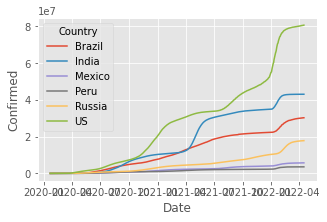

In [ ]:
fig = plt.gcf()
fig.set_size_inches(5,3)

sns.lineplot(data = pandemic_top, x = 'Date', y = 'Confirmed', hue = 'Country')

<AxesSubplot:xlabel='Date', ylabel='Deaths'>

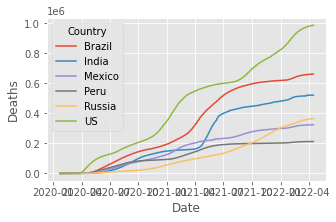

In [ ]:
fig = plt.gcf()
fig.set_size_inches(5,3)

sns.lineplot(data = pandemic_top, x = 'Date', y = 'Deaths', hue = 'Country')

<AxesSubplot:xlabel='Date', ylabel='Recovered'>

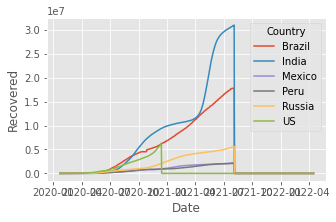

In [ ]:
fig = plt.gcf()
fig.set_size_inches(5,3)

sns.lineplot(data = pandemic_top, x = 'Date', y = 'Recovered', hue = 'Country')

Добавим столбец популяции

In [ ]:
pandemic_top.loc[pandemic_top['Country']=='Russia', 'Population'] = 145899956
pandemic_top.loc[pandemic_top['Country']=='Brazil', 'Population'] = 214832901
pandemic_top.loc[pandemic_top['Country']=='India', 'Population'] = 1401310563
pandemic_top.loc[pandemic_top['Country']=='Mexico', 'Population'] = 131046075
pandemic_top.loc[pandemic_top['Country']=='US', 'Population'] = 334058426
pandemic_top.loc[pandemic_top['Country']=='Peru', 'Population'] = 33587011
pandemic_top

,Country,Date,Confirmed,Recovered,Deaths,Deaths_on_1000,Population
19584,Brazil,2021-07-12,19113078,17014796.00,534540,27.97,214832901.00
19585,Brazil,2021-07-13,19161644,17037027.00,536199,27.98,214832901.00
19586,Brazil,2021-07-14,19217741,17128429.00,537735,27.98,214832901.00
19587,Brazil,2021-07-15,19272139,17141848.00,539344,27.99,214832901.00
19588,Brazil,2021-07-16,19315054,17252650.00,540733,28.00,214832901.00
...,...,...,...,...,...,...,...
147691,US,2020-10-21,8350148,3323354.00,221510,26.53,334058426.00
147692,US,2020-10-22,8429769,3353056.00,222348,26.38,334058426.00
147693,US,2020-10-23,8511431,3375427.00,223293,26.23,334058426.00
147694,US,2020-10-24,8589807,3406656.00,224253,26.11,334058426.00


Посчитаем нужные нам отношения

In [ ]:
pandemic_top['Deaths/Recovered'] = pandemic_top['Deaths']/pandemic_top['Recovered']
pandemic_top['Deaths/Confirmed'] = pandemic_top['Deaths']/pandemic_top['Confirmed']
pandemic_top['Confirmed/Population'] = pandemic_top['Confirmed']/pandemic_top['Population']
pandemic_top['Recovered/Population'] = pandemic_top['Recovered']/pandemic_top['Population']
pandemic_top['Deaths/Population'] = pandemic_top['Deaths']/pandemic_top['Population']

<AxesSubplot:xlabel='Date', ylabel='Deaths/Recovered'>

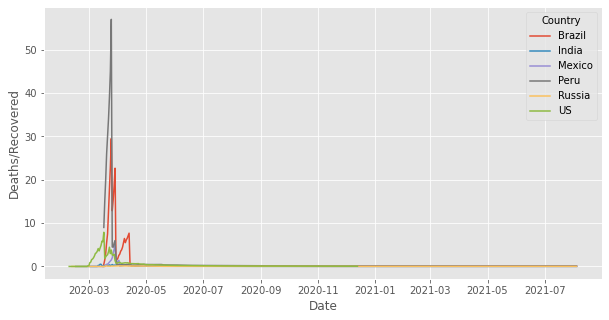

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10,5)

sns.lineplot(data = pandemic_top, x = 'Date', y = 'Deaths/Recovered', hue = 'Country')

<AxesSubplot:xlabel='Date', ylabel='Deaths/Confirmed'>

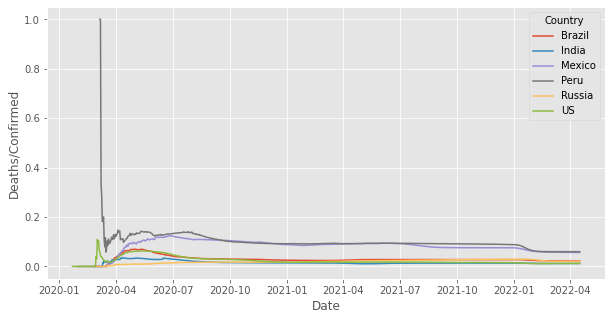

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10,5)

sns.lineplot(data = pandemic_top, x = 'Date', y = 'Deaths/Confirmed', hue = 'Country')

<AxesSubplot:xlabel='Date', ylabel='Confirmed/Population'>

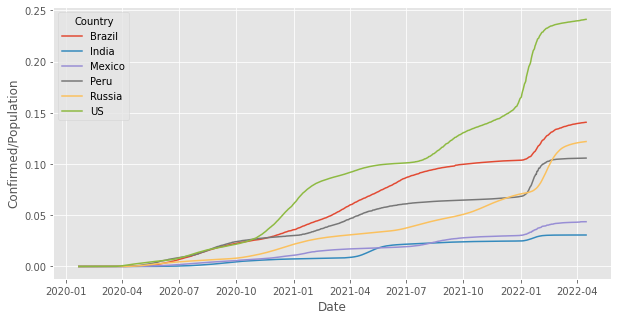

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10,5)

sns.lineplot(data = pandemic_top, x = 'Date', y = 'Confirmed/Population', hue = 'Country')

<AxesSubplot:xlabel='Date', ylabel='Recovered/Population'>

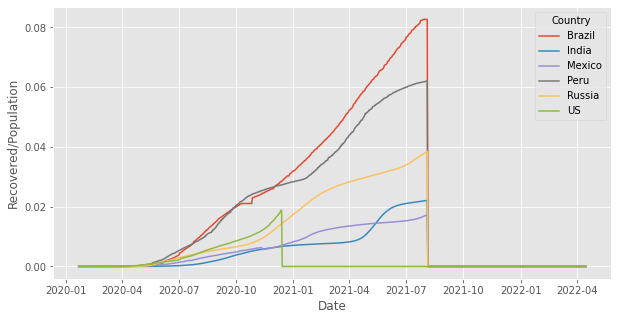

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10,5)

sns.lineplot(data = pandemic_top, x = 'Date', y = 'Recovered/Population', hue = 'Country')

<AxesSubplot:xlabel='Date', ylabel='Deaths/Population'>

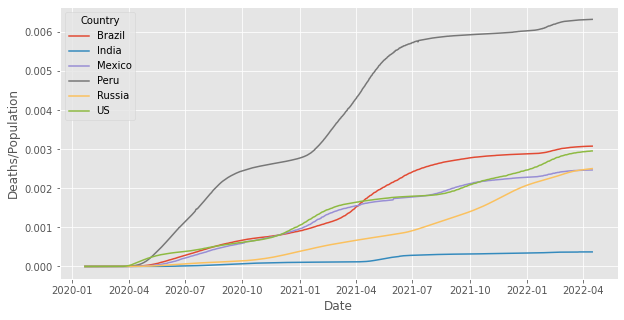

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10,5)

sns.lineplot(data = pandemic_top, x = 'Date', y = 'Deaths/Population', hue = 'Country')

<AxesSubplot:xlabel='Confirmed', ylabel='Deaths'>

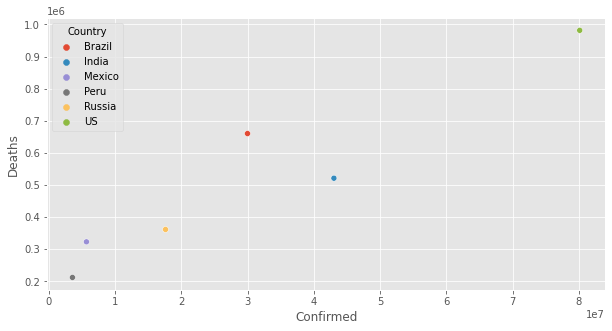

In [ ]:
fig = plt.gcf()
fig.set_size_inches(10,5)

sns.scatterplot(data = pandemic_top[pandemic_top['Date']=='2022-04-01'], x = 'Confirmed', y = 'Deaths', hue = 'Country')

Проанализировав получившиеся графики, можно сделать вывод, что ситуация стабилизировалась примерно к весне-лету 2020 года, после этого динамика заболеваемости и смерности почти не менялась. Худшая ситуация со смертностью по отношению к популяции в Перу и Мексике. По отношению заболевших к населению лидирует США, а выздоровевших к населению - Бразилия

#### 1.8. (5 баллов и 15 бонусных баллов)

Изучаемый вами датасет отражает мировую статистику распространения болезни. Однако эти данные не дают нам возможности сделать предположения о возможных факторах, которые влияют на скорость распространения, летальность, заразность и тд. Поэтому в наш датасет можно добавить новые признаки из других наборов данных, которые могут не только помочь при прогнозировании временного ряда, но и определить наиболее значимые факторы.

- Добавьте новый признак "количество дней со дня первого случая заражения".
- Добавьте еще не менее 5 новых признаков в датасет, которые могут быть значимым фактором распространения вируса. Сохраните полученный датасет. Вы можете его использовать в третьей части домашнего задания (за это вы сможете получить там дополнительные бонусные баллы).
- Исследуйте, как добавленные признаки соотносятся с трендами распространения короновируса в некоторых странах. Сделайте выводы.

*Подсказка: некоторые примеры признаков (список далеко не исчерпывающий и лучше хотя бы несколько придумать своих): количество дней с начала карантина; конинент; плотность населения; количество употребляемого алкоголя; распространенность летучих мышей; количество крокодилов на душу населения; количество туристов в год; уровень безработицы; температура; количество игроков в Plague Inc.; средний возраст или продолжительность жизни; и так далее. Вы можете использовать любой найденный датасет. Главное, чтобы у Вас получилось скомбинировать данные.*

  Примеры датасетов для вас:
  1. [500 Cities: Local Data for Better Health (2019)](https://www.kaggle.com/jaimeblasco/500-cities-local-data-for-better-health-2019)
  2. [Daily global surface summary from over 9000 weather stations from 1929 to now](https://www.kaggle.com/noaa/gsod)
  3. [Population by Country - 2020](https://www.kaggle.com/tanuprabhu/population-by-country-2020)



Добавим признак количества дней с начала пандемии в этой стране

In [ ]:
pandemic_start['Start_date'] = pandemic_start['Date']
pandemic_start

,Country,Date,Confirmed,Recovered,Deaths,Start_date
138720,Taiwan,2020-01-22 00:00:00,1,0.00,0,2020-01-22 00:00:00
141168,Thailand,2020-01-22 00:00:00,4,2.00,0,2020-01-22 00:00:00
70995,Japan,2020-01-22 00:00:00,2,0.00,0,2020-01-22 00:00:00
30730,China,2020-01-22 00:00:00,548,28.00,17,2020-01-22 00:00:00
147417,US,2020-01-22 00:00:00,1,0.00,0,2020-01-22 00:00:00
...,...,...,...,...,...,...
93960,Micronesia,2021-01-21 00:00:00,1,0.00,0,2021-01-21 00:00:00
74457,Kiribati,2021-05-18 00:00:00,1,0.00,0,2021-05-18 00:00:00
108620,Palau,2021-08-22 00:00:00,1,0.00,0,2021-08-22 00:00:00
144116,Tonga,2021-10-29 00:00:00,1,0.00,0,2021-10-29 00:00:00


In [ ]:
df = pd.merge(df, pandemic_start[['Country','Start_date']], how = "left", on = 'Country')
df.head()

,Country,Date,Confirmed,Recovered,Deaths,Deaths_on_1000,Start_date
0,Afghanistan,2020-01-22,0,0.00,0,NaN,2020-02-24 00:00:00
1,Afghanistan,2021-07-13,135889,82586.00,5849,43.04,2020-02-24 00:00:00
2,Afghanistan,2021-07-14,136643,82586.00,5923,43.35,2020-02-24 00:00:00
3,Afghanistan,2021-07-15,137853,82586.00,5983,43.40,2020-02-24 00:00:00
4,Afghanistan,2021-07-16,139051,82586.00,6072,43.67,2020-02-24 00:00:00


In [ ]:
df['Days_from_start'] = (df['Date']-df['Start_date']).apply(lambda x: x.days)
df = df.drop(df[df['Days_from_start']<0].index)
df.head()

,Country,Date,Confirmed,Recovered,Deaths,Deaths_on_1000,Start_date,Days_from_start
1,Afghanistan,2021-07-13,135889,82586.00,5849,43.04,2020-02-24 00:00:00,505
2,Afghanistan,2021-07-14,136643,82586.00,5923,43.35,2020-02-24 00:00:00,506
3,Afghanistan,2021-07-15,137853,82586.00,5983,43.40,2020-02-24 00:00:00,507
4,Afghanistan,2021-07-16,139051,82586.00,6072,43.67,2020-02-24 00:00:00,508
5,Afghanistan,2021-07-17,140224,82586.00,6098,43.49,2020-02-24 00:00:00,509


Добавим еще один датасет с гитхаба, где была еще графа популяция (reference.csv)

In [ ]:
population_by_country = pd.read_csv('population_by_country_2020.csv')
population_by_country.head()

Добавим еще 4 признака, которые как мне кажется, значительно влияют на распространение коронавируса

In [ ]:
population_by_country['Country'] = population_by_country['Country (or dependency)']
population_by_country = population_by_country.drop('Country (or dependency)',axis = 1)[['Country','Migrants (net)','Population (2020)','Density (P/Km²)','Med. Age','Urban Pop %']]
population_by_country.head()

In [ ]:
df = pd.merge(df, population_by_country, how = 'left', on = 'Country')
df.head()

In [ ]:
#df.to_csv('Pandemic_data_saved.csv',index=False)

Исследуем, как добавленные признаки влияют на динамику развития ситуации с коронавирусом

In [ ]:
df.info()

In [ ]:
sns.heatmap(df.corr(), annot = True)
plt.show()

Из добавленных признаков наибольшее влияние на все параметры влияет популяция

#### 1.9. (5 баллов)

Какие закономерности и тенденции бросились вам в глаза в ходе проделанного в разделе 1 анализа? Что оказалось неожиданным, а что, наоборот, ожидаемым? Почему? Напишите итоговые выводы по проделанному вами первичному анализу данных в рамках данного раздела.

Больше всего оказалось неожиданным как быстро в Европейских странах улучшилась ситуация по прошествии одного года, а в Латинских странах наоборот ухудшилась, заметно влияние уровня жизни. Ожидаемым было влияние популяции на течениее пандемии в стране, а также, что в странах с плохой санитарной обстановкой (например Индия) ситуация будет ухудшаться со временем

## Раздел 2. Статистический анализ и подготовка данных (28 баллов)


#### 2.1. (5 баллов)

В рамках задачи исследования и прогнозирования тенденций развития пандемии коронавируса, не очень интересно предсказывать количество заболевших/умерших к моменту окончания исследуемого периода данного датасета, поскольку все изменения значений будут близки к нулю - пандемия фактически уже окончилась. Какой в таком случае конец "известного" периода имело бы смысл взять? 

Также, с другой стороны: все ли данные от начала пандемии нам необходимы и полезны для анализа и прогнозирования? Почему? Обрежьте наш датасет с конца и (если необходимо) с начала, выделив тем самым интересующий нас рабочий период для анализа. Обязательно аргументируйте, почему вы решили взять период именно таким. Обрезку, на всякий случай, осуществляйте в копии датасета и сохраните исходный датасет на случай необходимости дополнительного анализа/анализа на других временных интервалах.

Это видоизмененные данные, которые были получены в ходе первой части дз(с добавленными столбцами и тд)

In [ ]:
df = pd.read_csv('Pandemic_data_saved.csv')

In [ ]:
df.describe()

,Confirmed,Recovered,Deaths,Deaths_on_1000,Days_from_start,Migrants (net),Population (2020),Density (P/Km²)
count,136913.00,136913.00,136913.00,136913.00,136913.00,123632.00,129040.00,129040.00
mean,813654.95,164436.63,15594.97,inf,383.02,-1525.62,41912371.23,389.59
std,3826533.94,1054590.82,63429.12,NaN,223.62,99610.78,160703921.98,2145.54
min,0.00,0.00,0.00,0.00,0.00,-532687.00,801.00,2.00
25%,3661.00,0.00,53.00,8.50,189.00,-14704.00,2145194.00,34.00
50%,36620.00,494.00,617.00,16.37,381.00,-1000.00,8678517.00,89.00
75%,304323.00,23377.00,5763.00,27.26,575.00,11200.00,26655083.00,206.00
max,80625120.00,30974748.00,988609.00,inf,815.00,543822.00,1440297825.00,26337.00


#### 2.2. (10 баллов)

Выделите временной ряд по одному из имеющихся у нас целевых признаков на ваш выбор. Для выделенного временного ряда проведите простой статистический анализ:

- Рассчитайте несколько первых лагов для временного ряда, выведите их на графике.
- Представьте временной ряд в виде последовательности разниц между значениями и визуализируйте её. Представьте его также в виде последовательности разниц разниц. Визуализируйте и это.
- Перейдите от временного ряда к логарифму временного ряда. Визуализируйте полученный ряд. Что можно сказать об изменениях?
- Осуществите декомпозицию временного ряда (тренд, сезонность, резидуалс). Постройте график тренда отдельно и график тренда на тех же осях, что и исходный временной ряд. Повторите проделанные действия для логарифма временного ряда. Имеется ли разница?
- Что вы можете сказать о стационарности временного ряда? Почему? Осуществите проверку на стационарность (желательно, с использованием методов математической статистики). Что можно сказать о стационарности последовательности разниц и последовательности разниц разниц? Также осуществите проверку на стационарность для этих рядов.

Какие выводы вы можете сделать из проделанного анализа?

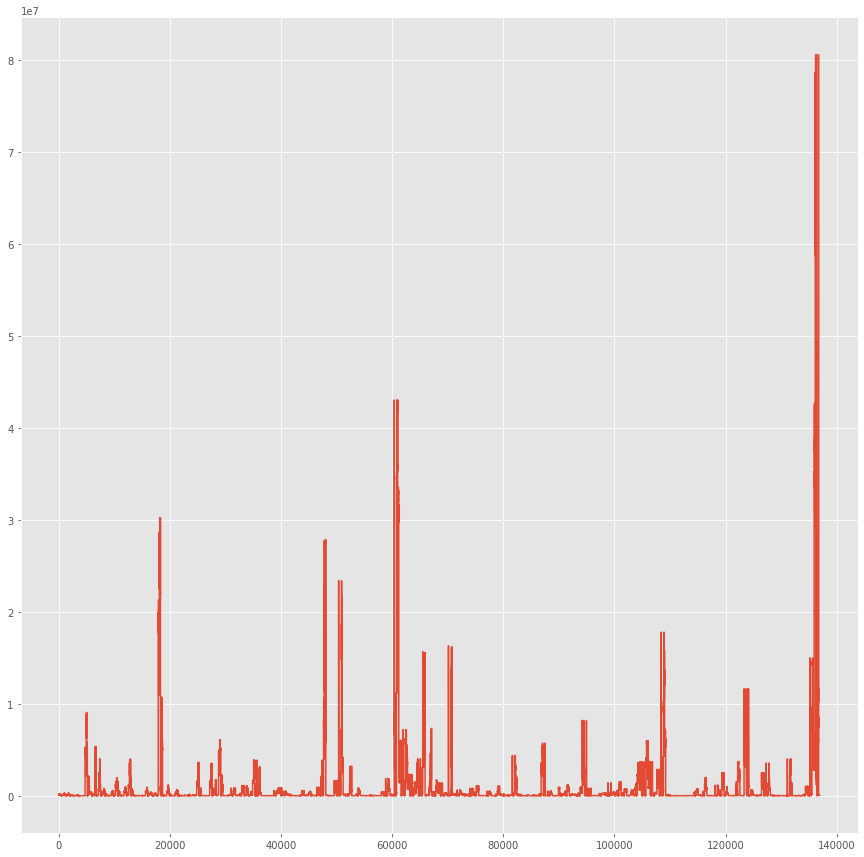

In [ ]:
# Выберем временной ряд по целевой переменной, количеству зараженных Covid - Confirmed
df['Confirmed'].plot()

In [ ]:
# Рассчитаем лаги
df["ConfirmedShift1"] = df.Confirmed.shift()

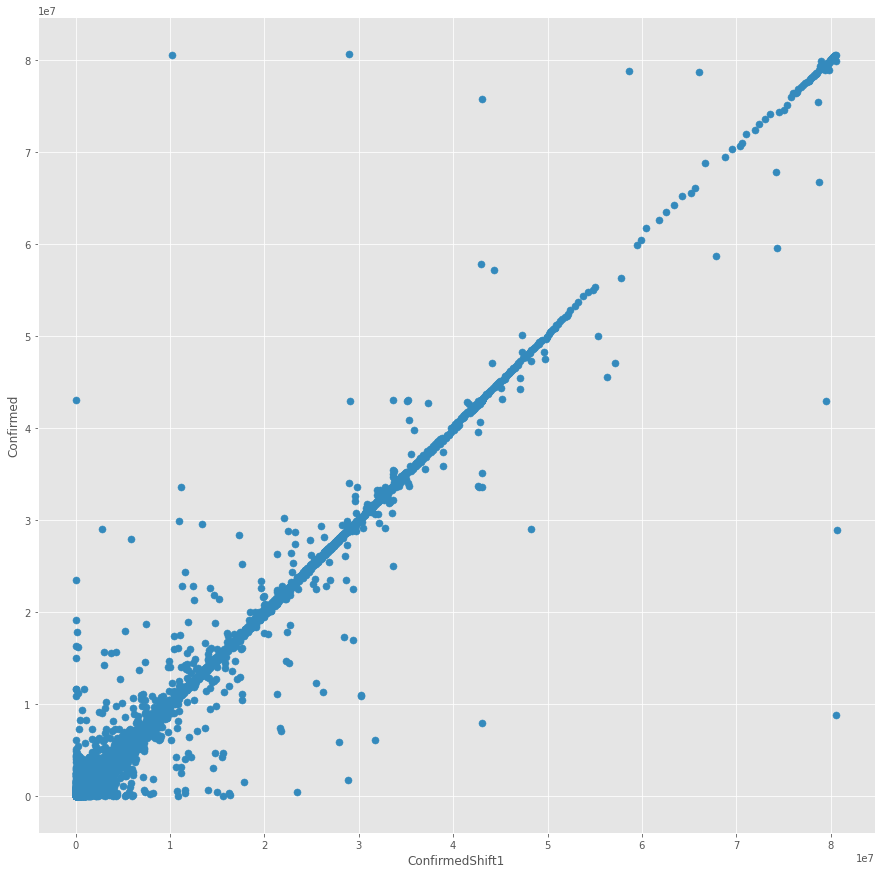

In [ ]:
# Вывод на графике 
df.plot(kind= "scatter", y = "Confirmed", x = "ConfirmedShift1", s = 50)

По графику видно, что при рассчете лага и при обычных значений Confirmed, значения на временном ряде
будут не сильно разбросаны друг от друга, будут почти одинаковыми.

In [ ]:
# Представим ряд в виде последовательности разниц 
df["confirmedDiff"] = df.Confirmed - df.ConfirmedShift1


,Country,Date,Confirmed,Recovered,Deaths,Deaths_on_1000,Start_date,Days_from_start,Migrants (net),Population (2020),Density (P/Km²),Med. Age,Urban Pop %,ConfirmedShift1,confirmedDiff,ConfirmedDiffShift1,confirmedDiffDiff,logConfirmed
date_ind,,,,,,,,,,,,,,,,,,
2020-01-01,Thailand,2020-01-31,19,8.00,0,0.00,2020-01-22,9,19444.00,69830779.00,137.00,40.00,51 %,NaN,NaN,NaN,NaN,2.94


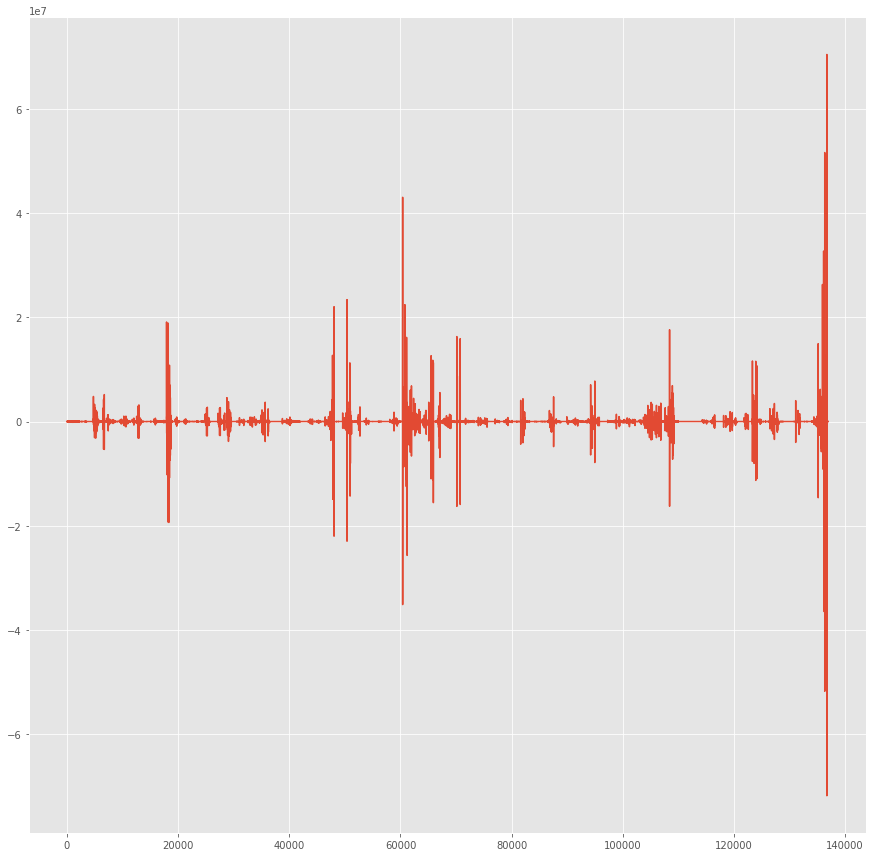

In [ ]:
# и визуализируем последовательность разниц
df.confirmedDiff.plot()

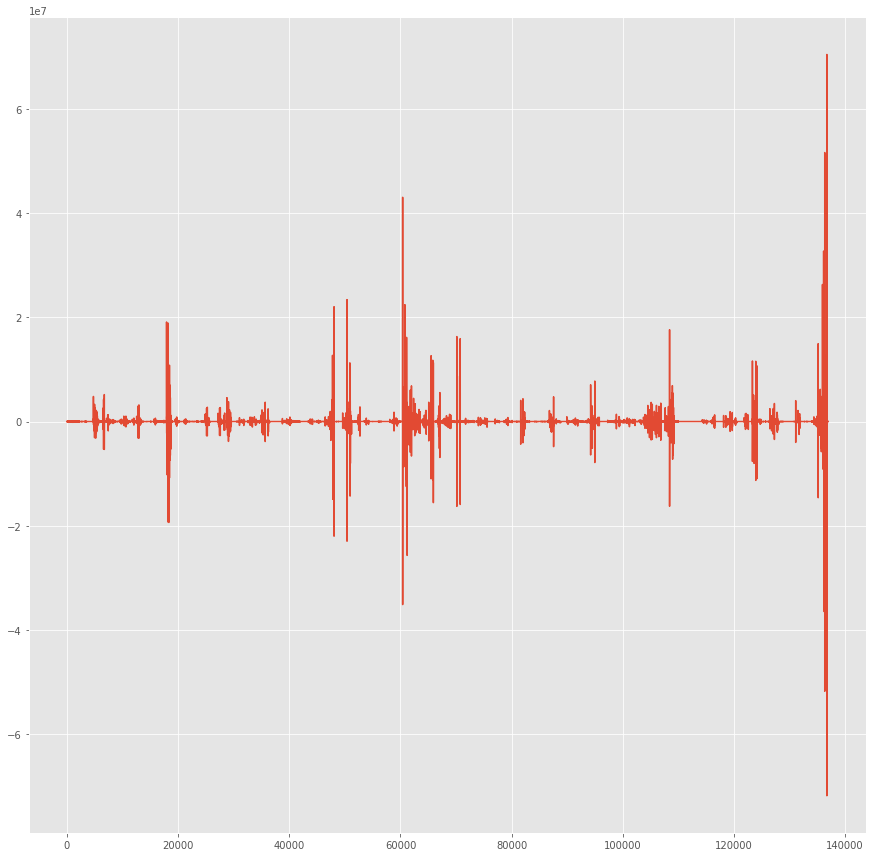

In [ ]:
# Представим в виде последовательности разниц разниц
df["ConfirmedDiffShift1"] = df.confirmedDiff.shift()
df["confirmedDiffDiff"] = df.confirmedDiff - df.ConfirmedDiffShift1
# и визуализируем последовательность разниц разниц
df.confirmedDiff.plot()

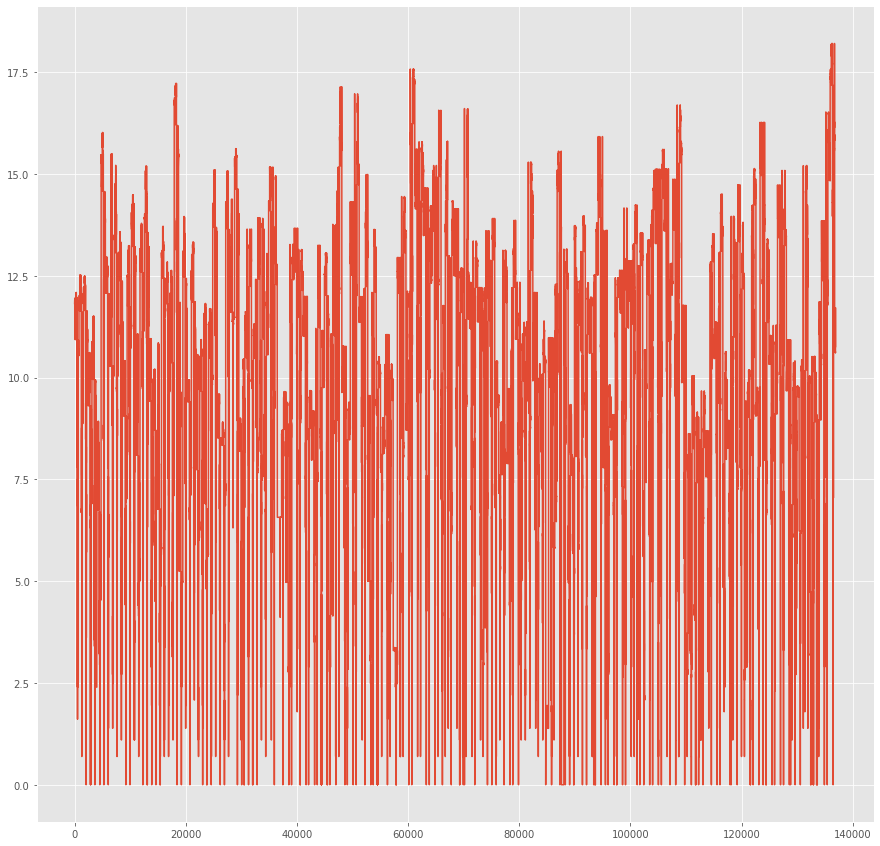

In [ ]:
# Перейдем от временного ряда к логарифму временного ряда
df['logConfirmed'] = np.log(df.Confirmed)
# И визуализируем его
df['logConfirmed'].plot()

Декомпозиция временного ряда

In [ ]:
# Отсортируем и добавим date в индекс
df.index = pd.PeriodIndex(df.Date, freq='M')
df.index.rename('date_ind', inplace = True)
df = df.sort_values(by = "date_ind")

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
df.index = df.index.to_timestamp()

In [ ]:
decomposition = seasonal_decompose(df.Confirmed, model = "additive", period = 12)

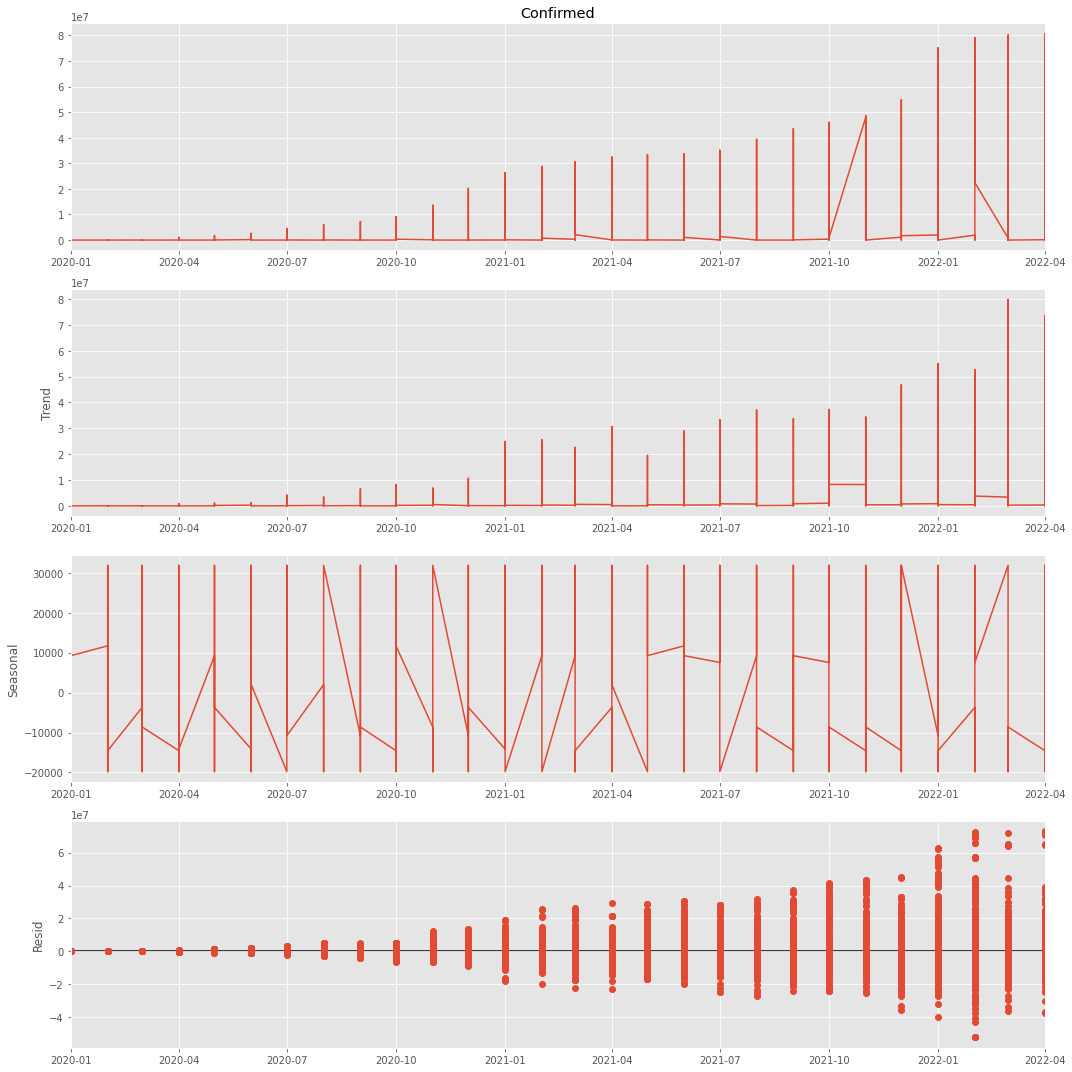

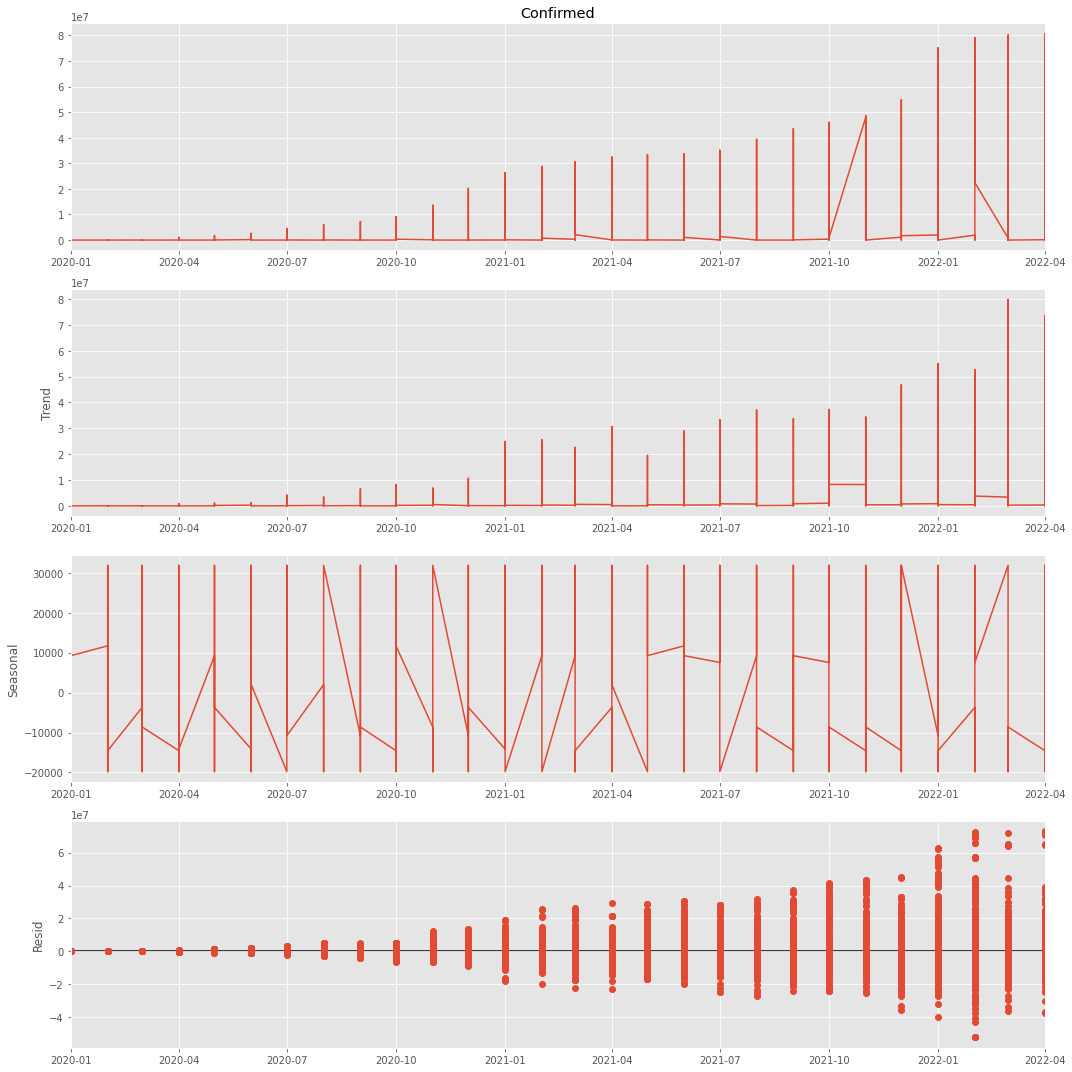

In [ ]:
decomposition.plot()

In [ ]:
#decomposition.trend[decomposition.trend.notna()]
trend = decomposition.trend

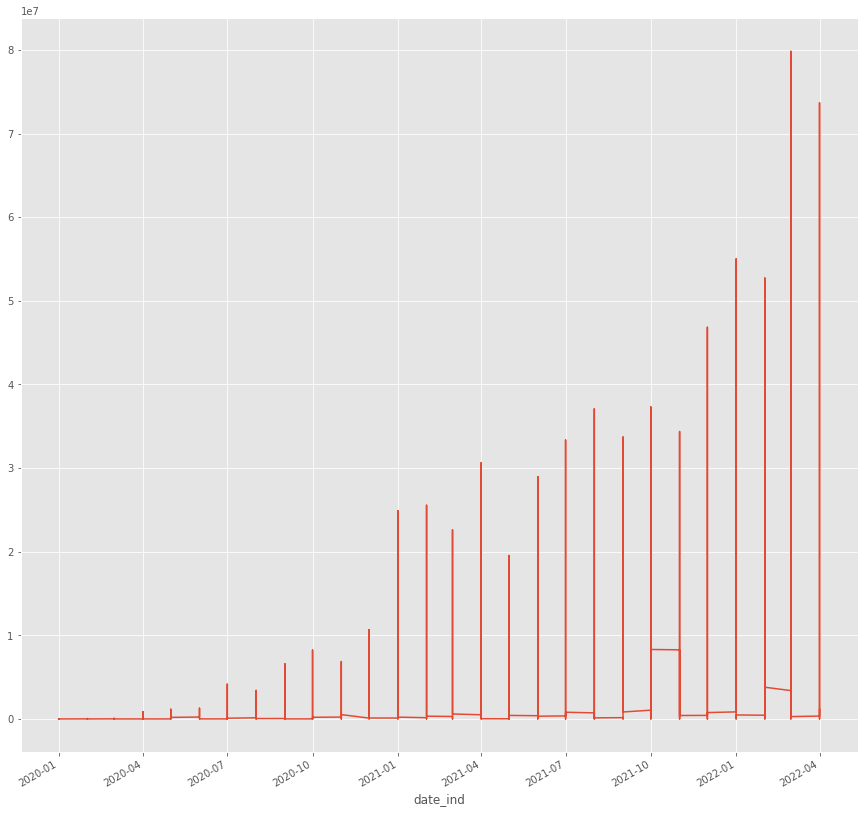

In [ ]:
trend.plot()

In [ ]:
# Для декомпозиции по логарифму удалим строки с бесконечными значениями логарифма
df = df[np.isfinite(df.logConfirmed) == True]

In [ ]:
# Теперь проведем декомпозицию с логарифмическими значениями
decomposition = seasonal_decompose(df.logConfirmed, model = "additive", period = 12)

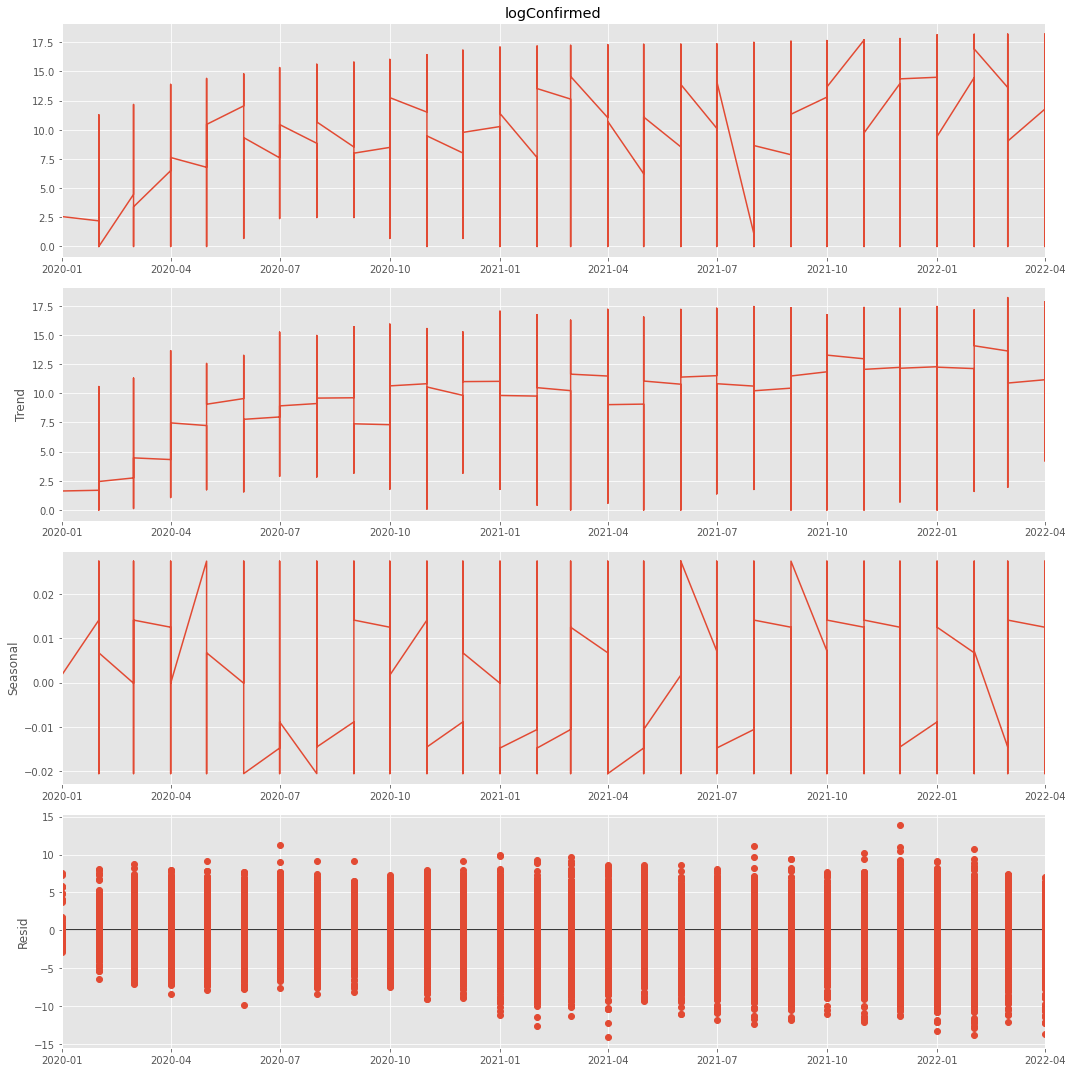

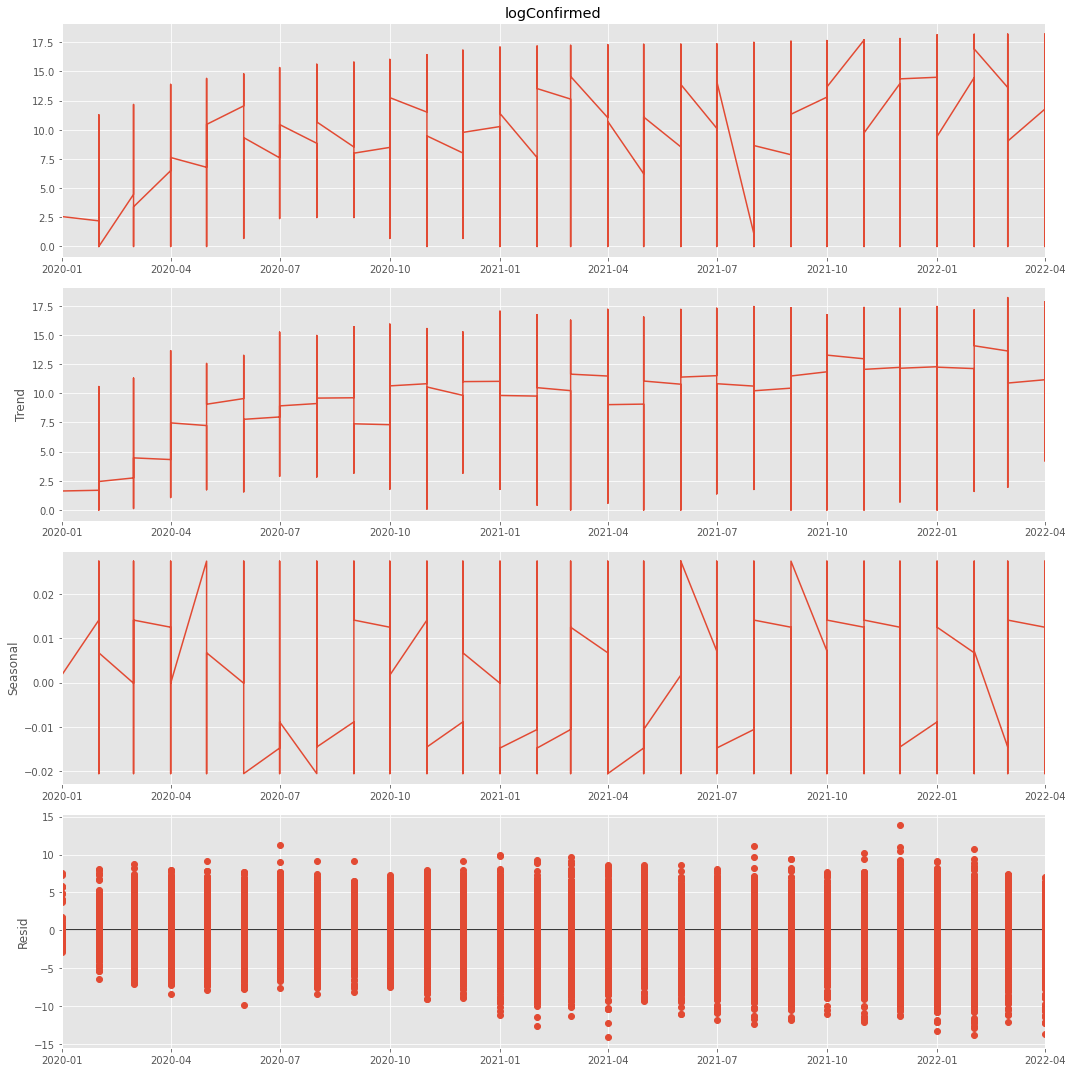

In [ ]:
decomposition.plot()

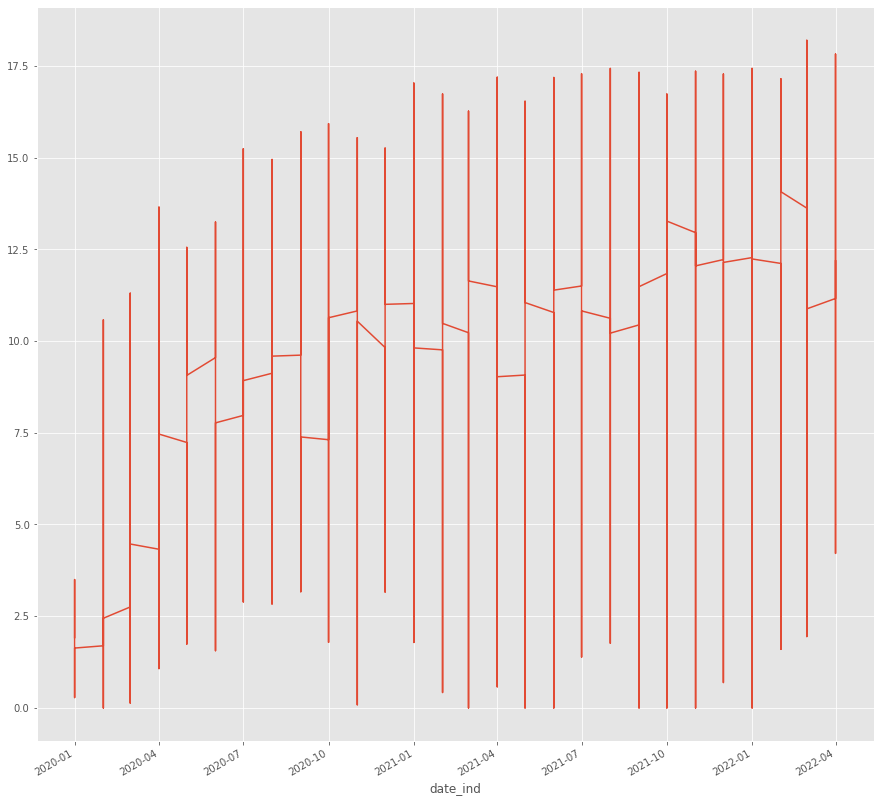

In [ ]:
trend = decomposition.trend
trend.plot()

Аналогично предыдущему опыту, при визуализации тренда в логарифмическом виде, в отличие от 
классического вида, разница минимальных значений между средними не такая ярко выраженная и 
удобна для построения регрессии.

In [ ]:
import statsmodels.api as sm

In [ ]:
# Проверим ряд на стационарность
test = sm.tsa.adfuller(df.Confirmed)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -32.358379671926
p-value:  0.0
Critical values:  {'1%': -3.430397789522463, '5%': -2.8615611222828736, '10%': -2.566781242641137}
Единичных корней нет, ряд стационарен


In [ ]:
df = df.drop(df[df.confirmedDiff.isna()].index)

In [ ]:
# Проверим ряд на стационарность
test = sm.tsa.adfuller(df.confirmedDiff)
print('Проведем проверку на стационарность ряда разниц')
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

Проведем проверку на стационарность ряда разниц
adf:  -38.78273628671076
p-value:  0.0
Critical values:  {'1%': -3.4303998090323633, '5%': -2.861562014869766, '10%': -2.5667817177347505}
Единичных корней нет, ряд стационарен


In [ ]:
df = df.drop(df[df.confirmedDiffDiff.isna()].index)

In [ ]:
test = sm.tsa.adfuller(df.confirmedDiffDiff)
print('Проведем проверку на стационарность ряда разниц разниц')
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

Проведем проверку на стационарность ряда разниц разниц
adf:  -94.57355774608213
p-value:  0.0
Critical values:  {'1%': -3.430399787037507, '5%': -2.86156200514844, '10%': -2.5667817125604193}
Единичных корней нет, ряд стационарен


Можно сделать вывод, что наши выбранные временные ряды стационарны, т.е. их среднее значение не меняется во времени. 
А также, что при приведении к логарифмическому виду временного
ряда мы получаем гораздо меньший разброс значений и переход. При визуализации разниц и разниц разниц мы можем увидеть, что
эти визуализации не сильно отличаются от стандартного графика, т.к. коронгавирус распространялся пошагово по экспоненте.

#### 2.3. (8 баллов)

Для выбранного вами в предыдущем задании временного ряда и еще одного любого постройте графики ACF и PACF. Что показывают эти функции и что можно увидеть на графиках? Прокомментируйте полученные результаты: являются ли временные ряды сезонными? Видна ли на графиках длина сезонной составляющей ряда? В случае присутствия сезонности, разбейте временной ряд на повторяющиеся фрагменты и нарисуйте их наложенными для иллюстрации этой сезонности.


In [ ]:
from statsmodels.tsa.stattools import acf, pacf

In [ ]:
ts_confirmed = df.Confirmed
ts_deaths = df.Deaths
ts_deaths.dropna(inplace = True)

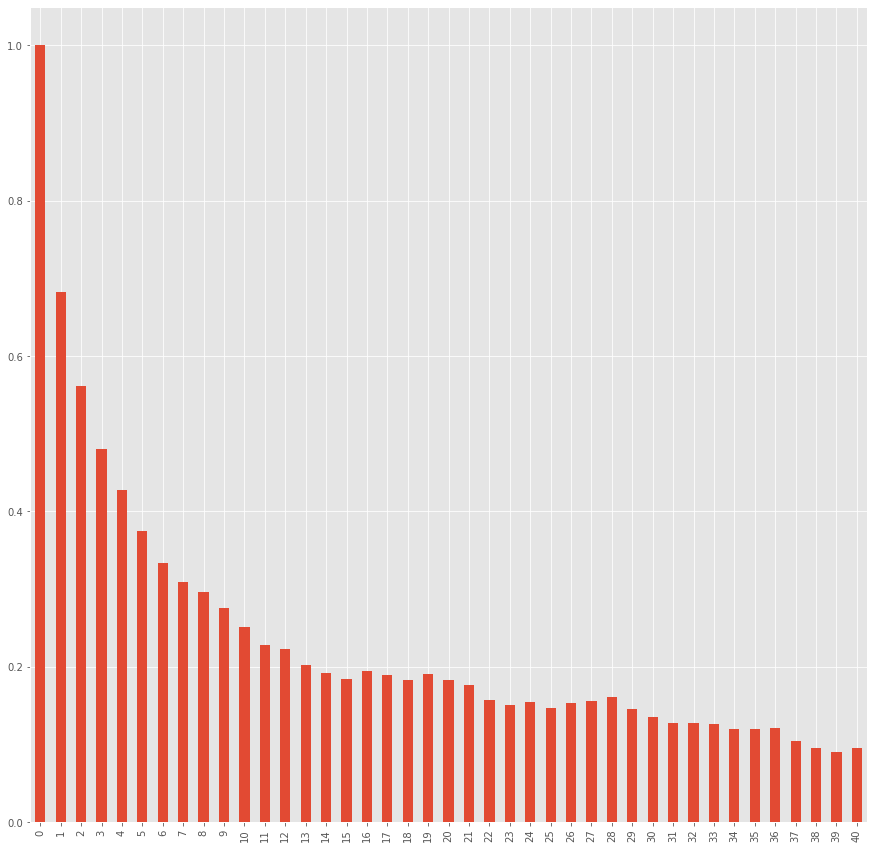

In [ ]:
acf_confirmed = acf(ts_confirmed)
ACF = pd.Series(acf_confirmed)
ACF.plot(kind = "bar")

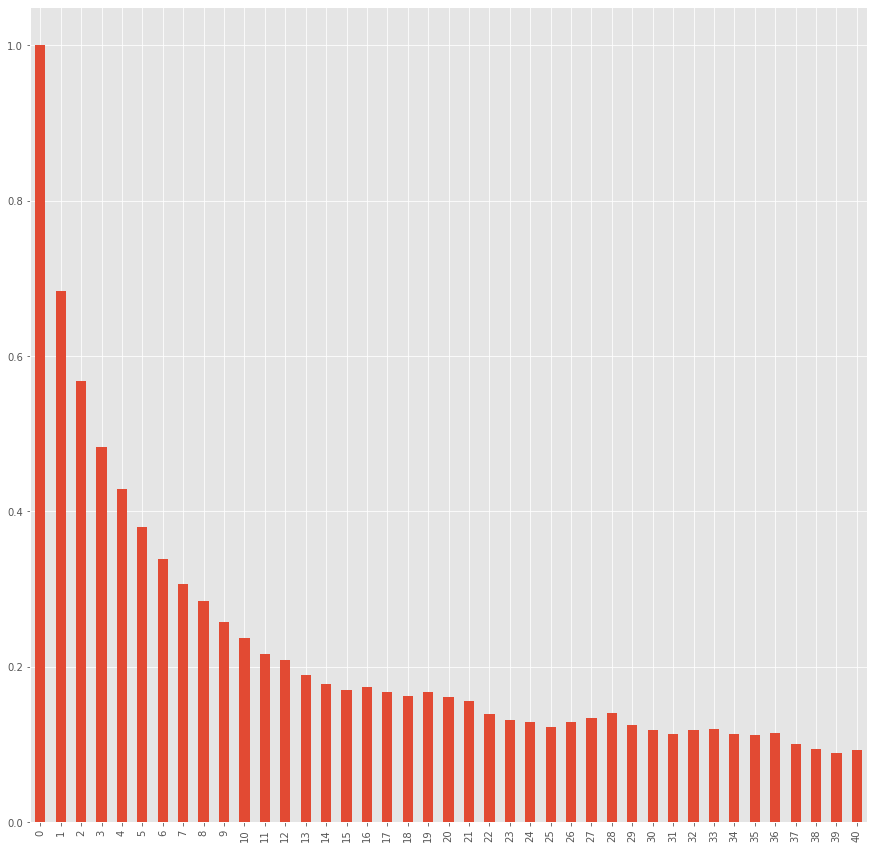

In [ ]:
acf_deaths = acf(ts_deaths)
ACF = pd.Series(acf_deaths)
ACF.plot(kind = "bar")

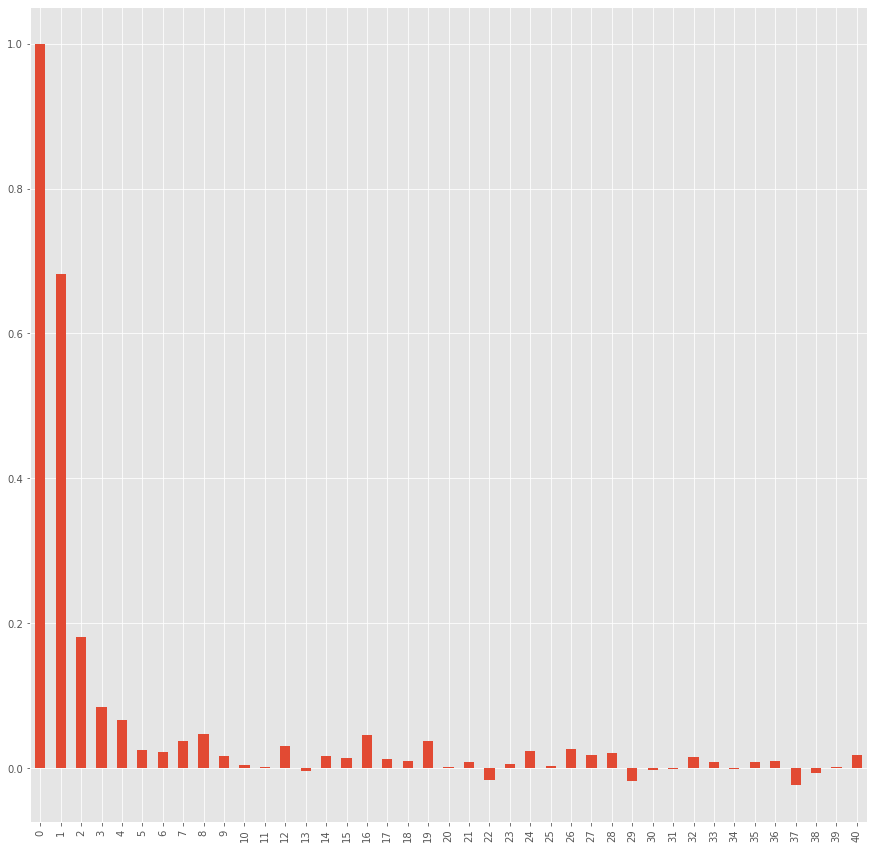

In [ ]:
pacf_confirmed = pacf(ts_confirmed, method='ols')
PACF = pd.Series(pacf_confirmed)
PACF.plot(kind = "bar")

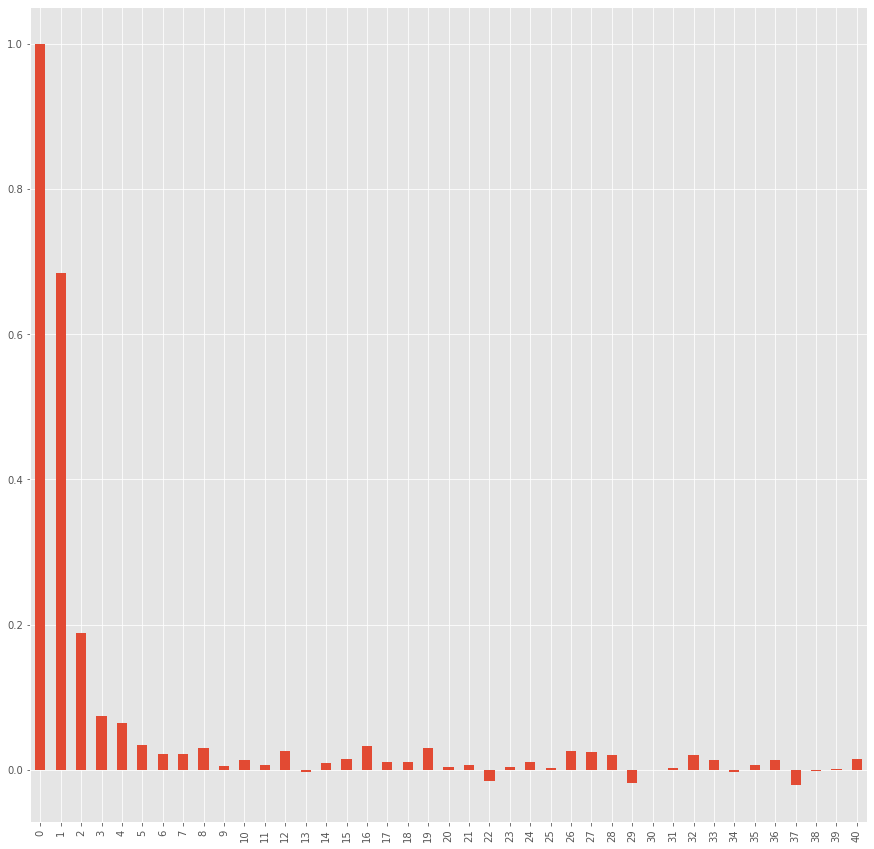

In [ ]:
pacf_deaths = pacf(ts_deaths, method='ols')
PACF = pd.Series(pacf_deaths)
PACF.plot(kind = "bar")

Можно отметить, что при построении ACF и PACF ярко выраженной сезонности не наблюдается, а PACF и ACF демонстрируют корреляцию временных рядов для их лагов.

#### 2.4. (5 баллов)

Вспомним, что для прогнозирования временного ряда необходимо разделить выборку на две составляющие (train и test). На составляющей train наша модель обучается и настраивает свои параметры, на составляющей test модель осуществляет предсказание (а затем мы можем это предсказание сравнить с реальными данными)

Осуществите разбиение датасета на выборку train и test. Соотношение размеров train/test на ваше усмотрение, но мы советуем вам выбрать 85% на 15% или 80% на 20% (при условии, что при этом в test остаётся не менее 20-25 наблюдений).

Отрисуйте не менее 3 разных временных рядов и визуально сделайте различимым разбиение на выборки — либо вертикальной чертой, либо разными цветами.

*Подсказка. Вам может помочь раздел "Прогнозирование в будущее" в семинаре 5*

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.index, df.Confirmed, 
                                                    train_size=0.8)

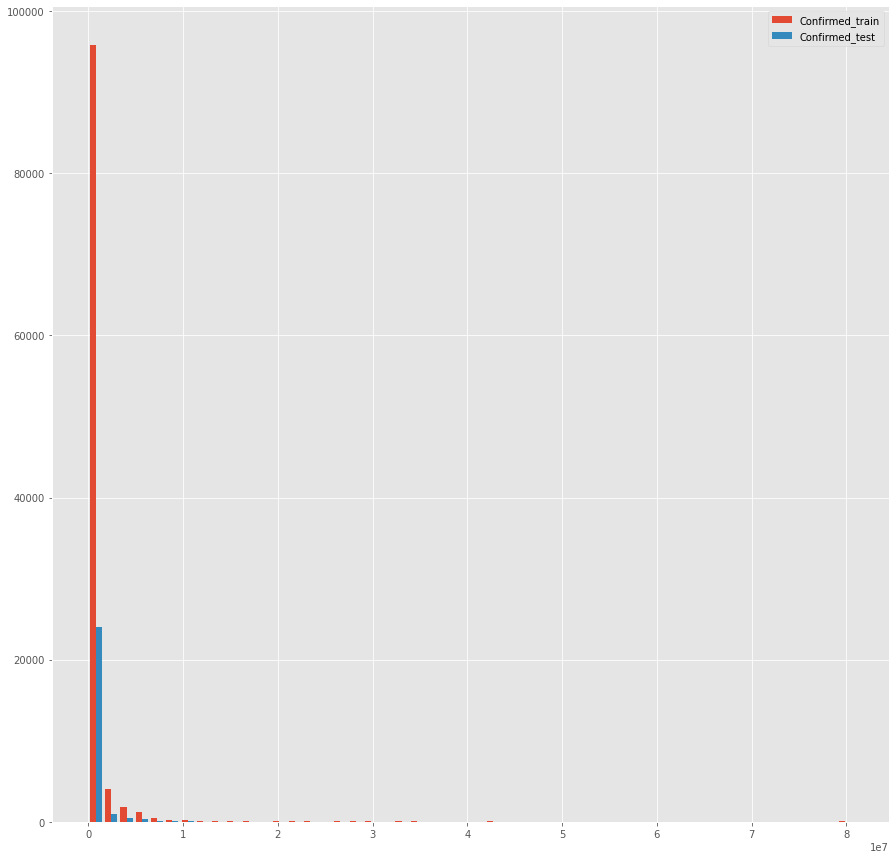

In [ ]:
plt.hist([y_train, y_test], bins=50, label=['Confirmed_train', 'Confirmed_test'])
plt.legend(loc='upper right')
plt.show()

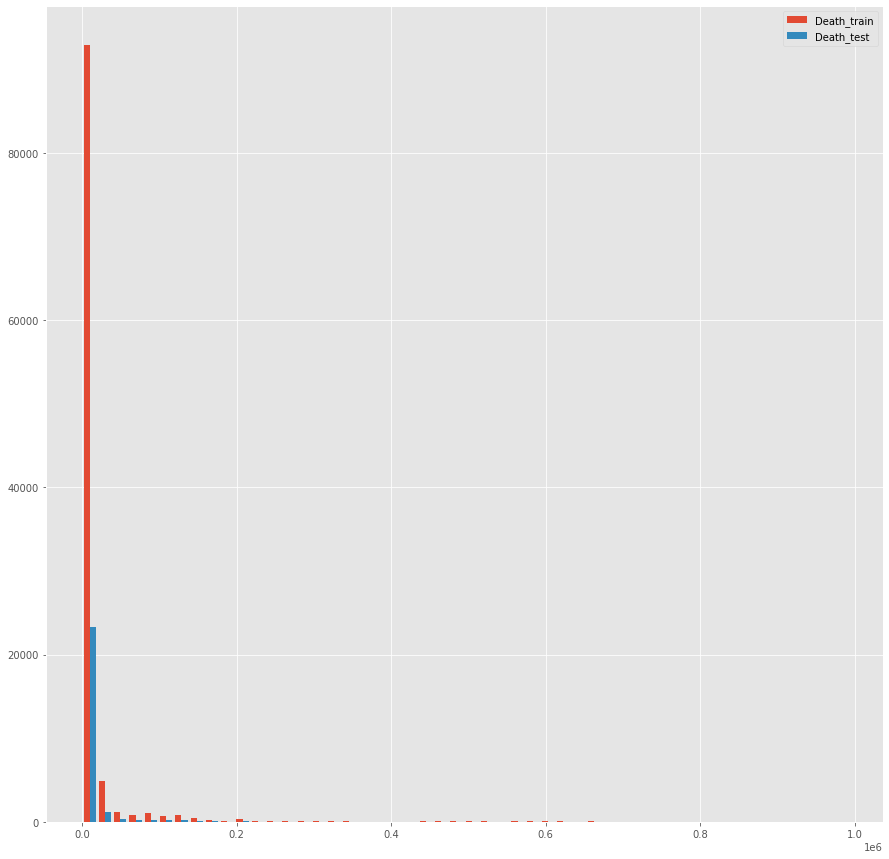

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.index, df.Deaths, 
                                                    train_size=0.8)
plt.hist([y_train, y_test], bins=50, label=['Death_train', 'Death_test'])
plt.legend(loc='upper right')
plt.show()

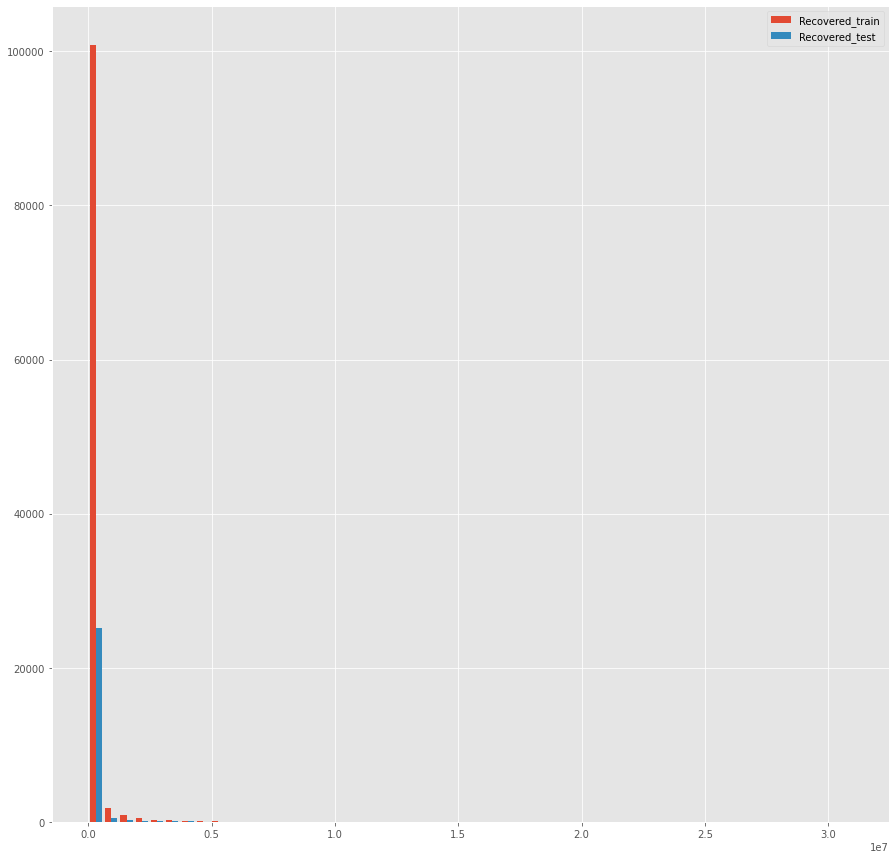

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.index, df.Recovered, 
                                                    train_size=0.8)
plt.hist([y_train, y_test], bins=50, label=['Recovered_train', 'Recovered_test'])
plt.legend(loc='upper right')
plt.show()

Мы использовали функцию train_test_split, чтобы разбить выборку на 80% для обучения и 20% для тестирования обученных значений.
После того, как выборки были разбиты. Те, значения, которые были для тестирования были отмечены синим цветом, 
те которые для обучения - красным. На рисунках наглядно видно, какие доли/сегменты значений были выбраны для тестирования
и как они распределены. Стоит отметить, что т.к. мы использовали функцию train_test_split, выборка произошла более менее 
равномерно (а не какие-то значения с краю диаграммы)

## Раздел 3. Модели. Прогнозирование временных рядов (60 баллов и 58 бонусных баллов)


В этой третьей и последней части домашнего задания вам предстоит построить несколько моделей и осуществить прогнозирование для временных рядов. Прогнозирование будем делать для такого показателя как летальность от вируса. Летальность можно рассчитывать по формуле:

$$ CFR = \frac{Deaths}{Confirmed} $$

Для каждого типа модели сделайте несколько прогнозов для не менее 3 разных стран/регионов/другое (на ваш обоснованный выбор). Главное, чтобы каждый из типов моделей прознозировал одинаковый набор данных, чтобы в конце можно было сделать выводы о качестве работы той или иной модели.

В качестве метрики качества взять RMSE.

Таким образом, по итогу построения и применения **каждой из моделей** должно быть следующее:
- Вывести массив прогнозов значений (массив имеет размер test-выборки)
- Визуализировать на графике значения ряда из train-выборки одним цветом и прогнозные значения модели (из массива прогнозов) другим цветом, на одних осях
- Визуализировать на графике значения всего ряда (и из train, и из test-выборок) одним цветом и прогнозные значения модели другим цветом, на одних осях (то есть по прогнозным значениям идет наложение двух графиков - подробнее см. в семинаре 5)
- Подсчитать метрику качества по test-выборке
- Добавить результаты метрики качества в общую сводную табличку (по строкам - название модели, по столбцам - RMSE для каждого из рядов - подробнее см. в семинаре 5)

*Примечание. Данный алгоритм необходимо повторять для каждой модели, учитывая разные параметры. Иными словами ARIMA(1,0,1) и ARIMA(2,0,1) - это разные модели*

Не забывайте обязательно сопровождать ваш код комментариями, графиками и выводами.

#### 3.1. Прогнозирование средним (Mean Constant Model)  (5 баллов)

Осуществите простое прогнозирование средним значением

In [ ]:
# Рассчитываем функцию для средней квадратичной ошибки
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

In [ ]:
df['CTF'] = df['Deaths']/df['Confirmed'] # Рассчитываем CTF для целевой переменной

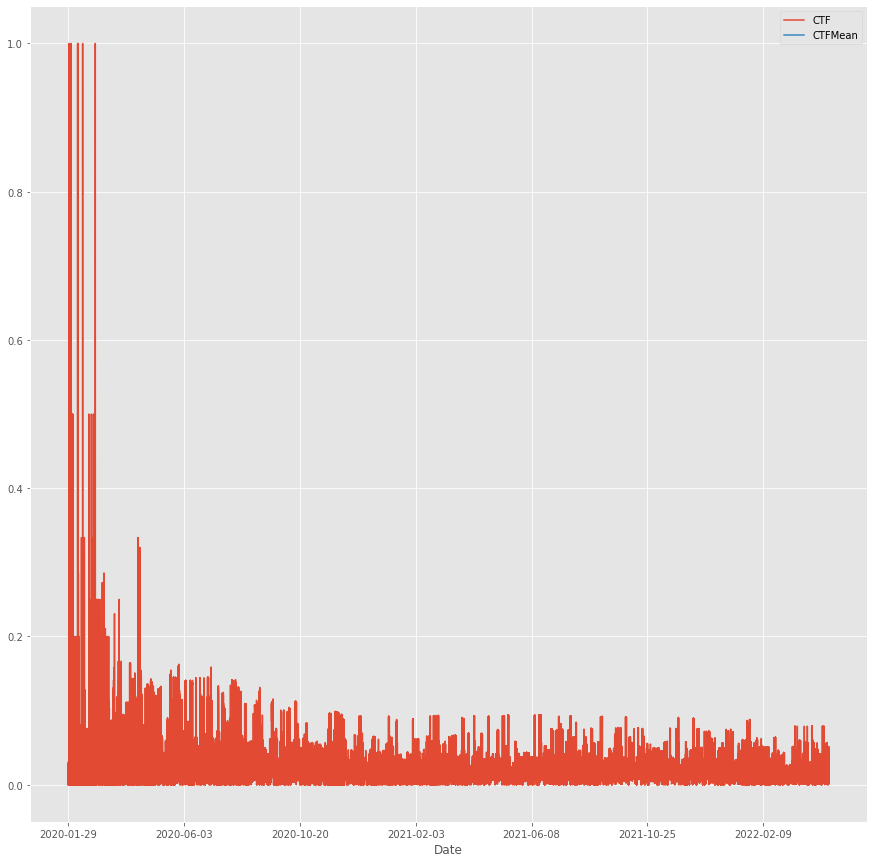

In [ ]:
model_mean_pred = df.Confirmed.mean()
df["CTFMean"] = np.exp(model_mean_pred)
df.plot(kind="line", x= 'Date', y = ["CTF", "CTFMean"])


In [ ]:
model_mean_RMSE = RMSE(df.CTFMean, df.CTF)
model_mean_RMSE

inf

In [ ]:
dfResults = pd.DataFrame(columns = ["Model", "RMSE"])
dfResults.loc[0,"Model"] = "Mean"
dfResults.loc[0,"RMSE"] = model_mean_RMSE

In [ ]:
dfResults.head()

,Model,RMSE
0,Mean,inf


При расчете средних, мы ушли в бесконечность. (Вероятно это связано с тем, что короновирус движется по экспоненте)

#### 3.2. Линейная модель (Linear Trend Model) (5 баллов)

Осуществите предсказание с помощью линейного тренда

In [ ]:
import statsmodels.formula.api as smf
model_linear = smf.ols('logConfirmed ~ Date', data = df).fit()

In [ ]:
model_linear_pred = model_linear.predict()

In [ ]:
df["confirmLinear"] = np.exp(model_linear_pred)

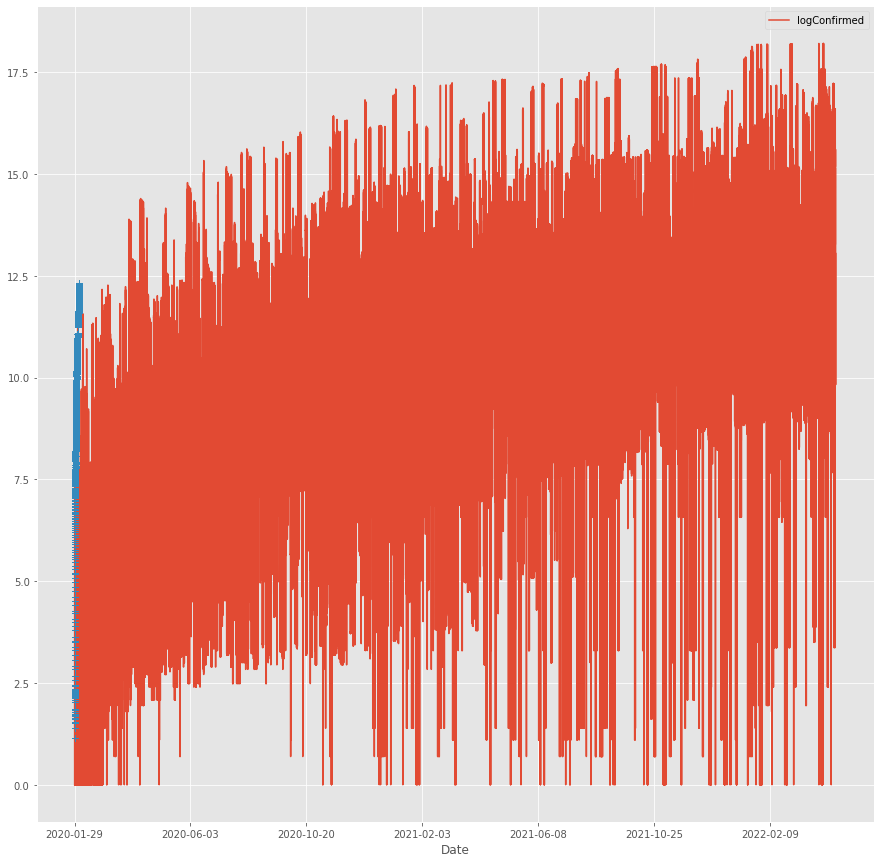

In [ ]:
df.plot(kind="line", x="Date", y = "logConfirmed")
plt.plot(df.Date,model_linear_pred, '+')

In [ ]:
model_linear_RMSE = RMSE(df.confirmLinear, df.Confirmed)
model_linear_RMSE
dfResults.loc[1,"Model"] = "Linear"
dfResults.loc[1,"RMSE"] = model_linear_RMSE
dfResults.head()

,Model,RMSE
0,Mean,inf
1,Linear,3888057.09


#### 3.3. Скользящее среднее (MA - Moving average) (5 баллов)

Постройте предсказание с помощью модели MA. Обязательно поэкспериментируйте с гиперпараметрами модели (и опишите, что вы делаете)

In [ ]:
from statsmodels.tsa.arima_model import ARMA
#model = ARMA(df.Confirmed, order=(0, 1))
#model_fitted = model.fit()

#### 3.4. Авторегрессионная модель (AR - Autoregressive model) (5 баллов)

Постройте предсказание с помощью модели AR. Обязательно поэкспериментируйте с гиперпараметрами модели (и опишите, что вы делаете)

In [ ]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(df.Confirmed, order=(0, 1))
model_fitted = model.fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


#### 3.5. ARMA (5 баллов)

Постройте предсказание, скомбинировав модели AR и MA. Обязательно поэкспериментируйте с гиперпараметрами модели (и опишите, что вы делаете)

In [ ]:
# Ваш код здесь

#### 3.6. Интегрированная модель авторегрессии — скользящего среднего (Auto Regressive Integrated Moving Average) - ARIMA (5 баллов)

Постройте предсказание, модернизировав модель ARMA и добавив интегрирующую компоненту. Обязательно поэкспериментируйте с гиперпараметрами модели (и опишите, что вы делаете)

#### 3.7. SARIMA (Seasonal Auto Regressive Integrated Moving Average) (5 баллов и 5 бонусных баллов)

Постройте предсказание, модернизировав модель ARIMA и добавив сезонную составляющую. Обязательно поэкспериментируйте с гиперпараметрами модели (и опишите, что вы делаете).

Бонусные баллы за это задание выставляются как совокупность за все задания по классам SARIMA (3.3 - 3.7), в случае если ваши модели получились хорошие, точные и вы верно настроили гиперпараметры, хорошо описав ваши действия.

*Примечание. Вы можете также почитать про Алгоритм Хиндмана-Хандакара для настройки SARIMA. Возможно, он сможет вам помочь и улучшить качество моделей*

In [ ]:
# Ваш код здесь

#### 3.8. ETS - Экспоненциальное сглаживание (Exponential smoothing) (15 баллов и 15 бонусных баллов)

Задание на основные баллы:

- Поработайте с классом моделей ETS (Exponential smoothing), подробно рассматривавшемся на лекции. Примените ETS(ANN), ETS(AAA) и еще минимум 3 любые (на ваш выбор) модели ETS. Осуществите настройку гиперпараметров во всех моделях. Сравните результаты между ними. Попробуйте объяснить, почему модели показывают такие результаты и такую разницу в результатах. Сделайте выводы.

Задания на бонусные баллы:

- Попробуйте теперь обучить ETS с автоматическим выбором по AIC (`AutoETS` в `sktime`). Что делает этот алгоритм? Что такое AIC? Какие результаты получаются? Сделайте выводы.

- Попробуйте также применить Double exponential smoothing и Triple exponential smoothing. Что это за модели? Какие результаты показывают они? Почему? Сделайте выводы.

- Нарисуйте для наилучшей модели предсказания **с доверительным интервалом** (если модель выдает его) и наложите их на истинные значения. В `sktime` `ETS` модель не выдает доверительные интервалы сразу, но при желании до них можно дотянуться!

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

In [ ]:
# Ваш код здесь

#### 3.9. KTR из orbit (8 бонусных баллов).

Попробуйте использовать модель KTR из библиотеки orbit для предсказания временных рядов.



In [ ]:
from orbit.models.ktrlite import KTRLite

In [ ]:
# Ваш код здесь

#### 3.10. Библиотека Prophet (10 бонусных баллов)
Попробуйте использовать библиотеку Prophet для предсказания временных рядов. [Документация](https://facebook.github.io/prophet/docs/quick_start.html).

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения.


In [ ]:
from prophet import Prophet

In [ ]:
# Ваш код здесь

#### 3.11 Линейная модель с регрессией (Linear Regression Model) (5 баллов и 10 бонусных баллов)

Примените линейную модель с регрессией для предсказания временных рядов.
Какие признаки оказались наиболее значимыми? Почему? Как вы это интерпретируете? Какие выводы можно сделать?

*Примечание. Это задание идет в тесной связке с заданием 1.8.*



In [ ]:
# Ваш код здесь

#### 3.12. Дополнительная модель (10 бонусных баллов)

Используйте еще одну какую-нибудь любую другую известную вам модель для предсказания временных рядов и заработайте дополнительные бонусные баллы!

In [ ]:
# Ваш код здесь

#### 3.13 Выводы (5 баллов)

Выведите все построенные вами модели на одних осях. Выведите общую сравнительную табличку по всем моделям, которые вы оценивали. Какие выводы вы можете сделать? Какая модель показала себя лучше всего? Как вы думаете почему? Одинаковые ли результаты эффективности получились у моделей на разных временных рядах? Какие итоги вы можете подвести по сравнению моделей друг с другом?


## Выводы по работе (5 баллов)

Напишите итоговые выводы по всему проделанному исследованию. С какими данными (временными рядами) вам понравилось работать, а с какими нет? Какие модели показались вам простыми и удобными, а какие менее понравились? Выявили ли вы какие-то закономерности в применимости моделей? Если в ходе работы, вы пробовали где-то разные варианты, разные подходы, и это не попало в описание предыдущих действий, опишите их тут. Что можно сказать в целом о том, как мы решили задачу, изначально поставленную перед нами? Подведите окончательные итоги

<здесь место для ваших выводов>